In [557]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from tensorflow.keras import Sequential,layers,losses,utils,Input
from tensorflow.keras.layers import Dense,LSTM,Dropout,concatenate,Flatten, Conv1D, MaxPooling1D,Activation,RepeatVector,TimeDistributed
import tensorflow as tf
# from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Bidirectional,GRU,Lambda,Dot,Concatenate
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
from keras.layers import Bidirectional,LSTM,GRU,Lambda,Dot,Concatenate

import matplotlib.pyplot as plt
import matplotlib

from sklearn.decomposition import PCA
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras import optimizers
from keras.models import load_model

In [558]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [559]:
data=pd.read_csv('/private/数据/2019-2022sydatag2.csv')

In [560]:
data

date  Precipitation  Temperature  Humidity  \
0        2019/1/1 23:00            0.0         -9.5        81   
1         2019/1/2 0:00            0.0          2.5        28   
2         2019/1/2 1:00            0.0         -8.6        54   
3         2019/1/2 2:00            0.0          1.4        68   
4         2019/1/2 3:00            0.0        -14.6        86   
...                 ...            ...          ...       ...   
35037  2022/12/31 19:00            0.0        -15.8        79   
35038  2022/12/31 20:00            0.0        -16.3        80   
35039  2022/12/31 21:00            0.0        -16.9        80   
35040  2022/12/31 22:00            0.0        -17.5        80   
35041  2022/12/31 23:00            0.0        -18.0        82   

       Barometric pressure  wind speed  visibility  
0                   1016.6         0.8        5872  
1                   1015.7         2.7       21332  
2                   1018.7         0.8        4061  
3                   1016.6         3.0        4373  
4                   1020.1         0.4        2516  
...                    ...         ...         ...  
35037               1027.9         0.7       11847  
35038               1028.0         0.8       11302  
35039               1027.9         0.3       12506  
35040               1028.6         0.4       12639  
35041               1029.0         0.8       11588  

[35042 rows x 7 columns]

In [561]:
data.columns

Index(['date', 'Precipitation', 'Temperature', 'Humidity',
       'Barometric pressure', 'wind speed', 'visibility'],
      dtype='object')

In [562]:
col=[ 'date', 'Precipitation', 'Temperature', 'Humidity',
       'Barometric pressure', 'wind speed', 'visibility']
datacol=data[col]

In [563]:
datacol.isnull().sum()

date                   0
Precipitation          0
Temperature            0
Humidity               0
Barometric pressure    0
wind speed             0
visibility             0
dtype: int64

In [564]:
# 直接删除缺失值
datashan=datacol.dropna()

In [565]:
datashan.shape

(35042, 7)

In [566]:
datashan.describe()

Precipitation   Temperature      Humidity  Barometric pressure  \
count   35042.000000  35042.000000  35042.000000         35042.000000   
mean        0.099966      9.286787     62.608299          1010.241816   
std         0.898044     13.352207     24.074863             9.905663   
min         0.000000    -26.000000      7.000000           986.500000   
25%         0.000000     -1.700000     43.000000          1001.800000   
50%         0.000000     11.200000     63.000000          1010.300000   
75%         0.000000     20.700000     84.000000          1018.200000   
max        56.800000     36.100000    100.000000          1038.400000   

         wind speed    visibility  
count  35042.000000  35042.000000  
mean       2.074822  20413.723646  
std        1.502060   9885.101852  
min        0.000000     38.000000  
25%        0.900000  11358.000000  
50%        1.800000  23083.000000  
75%        2.900000  30000.000000  
max       16.900000  35000.000000

In [567]:
datashan.head(8)

date  Precipitation  Temperature  Humidity  Barometric pressure  \
0  2019/1/1 23:00            0.0         -9.5        81               1016.6   
1   2019/1/2 0:00            0.0          2.5        28               1015.7   
2   2019/1/2 1:00            0.0         -8.6        54               1018.7   
3   2019/1/2 2:00            0.0          1.4        68               1016.6   
4   2019/1/2 3:00            0.0        -14.6        86               1020.1   
5   2019/1/2 4:00            0.0          3.0        62               1015.6   
6   2019/1/2 5:00            0.0         -5.2        90               1018.0   
7   2019/1/2 6:00            0.0        -13.3        87               1021.0   

   wind speed  visibility  
0         0.8        5872  
1         2.7       21332  
2         0.8        4061  
3         3.0        4373  
4         0.4        2516  
5         3.2        4360  
6         0.7        1003  
7         1.1        1915

In [568]:
datashan.max()

date                   2022/12/31 23:00
Precipitation                      56.8
Temperature                        36.1
Humidity                            100
Barometric pressure              1038.4
wind speed                         16.9
visibility                        35000
dtype: object

# 使用LSTM模型进行单步预测，输入特征为降水量输出为降水量。

In [572]:
features = ['Precipitation']
target = ['Precipitation']
X = data[features].values
y = data[target].values

In [573]:
X.shape

(35042, 1)

In [571]:
y.shape

(35042, 1)

In [22]:
test_split=round(len(X)*0.20)
df_for_training=X[:-7008]
df_for_testing=X[-7008:]
print(df_for_training.shape)
print(df_for_testing.shape)

(28034, 1)
(7008, 1)


In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [28]:
df_for_testing_scaled

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [29]:
def createXY(dataset,n_past):
  dataX = []
  dataY = []
  for i in range(n_past, len(dataset)):
          dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
          dataY.append(dataset[i,0])
  return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,48)
testX,testY=createXY(df_for_testing_scaled,48)

In [30]:
from keras.layers import LSTM, Dense, Dropout

from keras.layers import LSTM, Dense, Dropout

# 定义修改后的LSTM模型
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# # 定义LSTM模型
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# # 定义模型参数
# input_shape = (trainX.shape[1], trainX.shape[2])  # 输入形状
# units = 64  # LSTM 单元数量
# output_dim = 1  # 输出维度（预测的特征数量）

# # 构建 BI-LSTM 模型
# bilstm_model = build_bilstm_model(input_shape, units, output_dim)

# # 编译模型
# bilstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # 查看模型结构
# bilstm_mode

2024-05-14 21:01:25.223374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:0d:00.0, compute capability: 8.6
2024-05-14 21:02:05.286073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 21:02:05.288331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_

In [31]:
# 训练模型
history = model.fit(trainX, trainY, epochs=70, batch_size=16, validation_data=(testX, testY), verbose=2)

Epoch 1/70


2024-05-14 21:02:14.757686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-14 21:02:14.759693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-14 21:02:14.760840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1750/1750 - 53s - loss: 4.0114e-04 - val_loss: 8.3112e-04 - 53s/epoch - 30ms/step
Epoch 2/70
1750/1750 - 31s - loss: 3.8927e-04 - val_loss: 8.4270e-04 - 31s/epoch - 18ms/step
Epoch 3/70
1750/1750 - 27s - loss: 3.8962e-04 - val_loss: 8.8109e-04 - 27s/epoch - 16ms/step
Epoch 4/70
1750/1750 - 25s - loss: 3.8594e-04 - val_loss: 8.4411e-04 - 25s/epoch - 14ms/step
Epoch 5/70
1750/1750 - 34s - loss: 3.8651e-04 - val_loss: 8.1432e-04 - 34s/epoch - 20ms/step
Epoch 6/70
1750/1750 - 47s - loss: 3.8299e-04 - val_loss: 8.4992e-04 - 47s/epoch - 27ms/step
Epoch 7/70
1750/1750 - 25s - loss: 3.8083e-04 - val_loss: 8.0262e-04 - 25s/epoch - 14ms/step
Epoch 8/70
1750/1750 - 43s - loss: 3.7850e-04 - val_loss: 7.9654e-04 - 43s/epoch - 25ms/step
Epoch 9/70
1750/1750 - 21s - loss: 3.7647e-04 - val_loss: 7.9526e-04 - 21s/epoch - 12ms/step
Epoch 10/70
1750/1750 - 42s - loss: 3.7153e-04 - val_loss: 8.1277e-04 - 42s/epoch - 24ms/step
Epoch 11/70
1750/1750 - 24s - loss: 3.7274e-04 - val_loss: 7.6667e-04 - 24s/epoc

# CEEMDAN分解

In [574]:
# 导入相应的库
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import warnings
import scipy
from scipy import stats

In [575]:
X

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [576]:
X.shape

(35042, 1)

In [577]:
scipy.__version__

'1.7.0'

In [578]:
import statsmodels
statsmodels.__version__

'0.14.1'

In [579]:
from PyEMD import CEEMDAN, Visualisation

In [580]:
X1 = data['Precipitation']

In [581]:
X1

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35037    0.0
35038    0.0
35039    0.0
35040    0.0
35041    0.0
Name: Precipitation, Length: 35042, dtype: float64

In [ ]:
#Decomposition results of RV for stock indices.

ceemdan = CEEMDAN()
ceemdan.ceemdan(X1.values.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, len(X1), 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [549]:
decompose_data = pd.DataFrame(np.vstack((imfs_close, res_close)).T,columns = ['IMF%d'%(i+1) for i in range(len(imfs_close))] + ['Res'])

NameError: name 'imfs_close' is not defined

In [550]:
decompose_data

list1     list2         list3
0    0.000000e+00  1.000000  0.000000e+00
1    2.101245e-02  0.999779  2.101709e-02
2    4.201562e-02  0.999117  4.205276e-02
3    6.300024e-02  0.998014  6.312564e-02
4    8.395704e-02  0.996469  8.425452e-02
..            ...       ...           ...
295 -8.395704e-02  0.996469 -8.425452e-02
296 -6.300024e-02  0.998014 -6.312564e-02
297 -4.201562e-02  0.999117 -4.205276e-02
298 -2.101245e-02  0.999779 -2.101709e-02
299 -2.449294e-16  1.000000 -2.449294e-16

[300 rows x 3 columns]

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.callbacks import EarlyStopping

In [145]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


# 按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data, window_size):
    train_num = int(len(serie_data) * 0.7)
    val_num = int(len(serie_data) * 0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size = 0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行

    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造测试集
    x_test, y_test = TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size,
                                end_index=len(serie_data),
                                step=step, target_size=target_size, point_time=True, true=serie_data)
    return x_train, y_train, x_val, y_val, x_test, y_test




In [33]:
from tensorflow.keras.optimizers import Adam

y_pre_list = []
y_test_list = []
window_size = 12

for column in decompose_data.columns:
    serie_data = decompose_data[column]
    x_train, y_train, x_val, y_val, x_test, y_test = get_tain_val_test(serie_data, window_size)
    
    # 在每次循环开始时重新实例化模型
    model = Sequential([
        GRU(50, input_shape=(window_size, 1), return_sequences=False),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=16, verbose=1)
    
    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)

# 这里可以添加代码以评估模型性能，比如计算每一列的MSE或MAE

2024-05-15 14:52:03.487040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:0d:00.0, compute capability: 8.6
2024-05-15 14:52:22.011218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 14:52:22.012960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_

Epoch 1/20


2024-05-15 14:53:14.087665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 14:53:14.089416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 14:53:14.090571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

   1/1533 [..............................] - ETA: 5:16:47 - loss: 0.1189

2024-05-15 14:53:26.124601: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1530/1533 [============================>.] - ETA: 0s - loss: 0.7316

2024-05-15 14:54:00.006975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 14:54:00.008936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 14:54:00.010011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 53s 26ms/step - loss: 0.7308 - val_loss: 0.8939
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.4881 - val_loss: 0.6999
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.3969 - val_loss: 0.6363
Epoch 4/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.3377 - val_loss: 0.6469
Epoch 5/20
1533/1533 [==============================] - 22s 14ms/step - loss: 0.2924 - val_loss: 0.5113
Epoch 6/20
1533/1533 [==============================] - 24s 15ms/step - loss: 0.2664 - val_loss: 0.5308
Epoch 7/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.2409 - val_loss: 0.5268
Epoch 8/20
1533/1533 [==============================] - 23s 15ms/step - loss: 0.2179 - val_loss: 0.4664
Epoch 9/20
1533/1533 [==============================] - 14s 9ms/step - loss: 0.2022 - val_loss: 0.4596
Epoch 10/20
1533/1533 [==============================] - 16s 10ms/step - loss:

2024-05-15 15:00:07.920203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:00:07.921949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:00:07.923017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 4s 3ms/step


2024-05-15 15:00:16.656844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:00:16.658541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:00:16.659583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:00:33.888038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:00:33.889651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:00:33.890770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1525/1533 [============================>.] - ETA: 0s - loss: 0.2418

2024-05-15 15:01:06.218195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:01:06.219961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:01:06.220995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 37s 16ms/step - loss: 0.2445 - val_loss: 0.2374
Epoch 2/20
1533/1533 [==============================] - 20s 13ms/step - loss: 0.1068 - val_loss: 0.1654
Epoch 3/20
1533/1533 [==============================] - 23s 15ms/step - loss: 0.0904 - val_loss: 0.1559
Epoch 4/20
1533/1533 [==============================] - 28s 18ms/step - loss: 0.0709 - val_loss: 0.1335
Epoch 5/20
1533/1533 [==============================] - 19s 13ms/step - loss: 0.0561 - val_loss: 0.1451
Epoch 6/20
1533/1533 [==============================] - 22s 15ms/step - loss: 0.0501 - val_loss: 0.1699
Epoch 7/20
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0461 - val_loss: 0.1797
Epoch 8/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0449 - val_loss: 0.1715
Epoch 9/20
1533/1533 [==============================] - 27s 18ms/step - loss: 0.0386 - val_loss: 0.1261
Epoch 10/20
1533/1533 [==============================] - 17s 11ms/step - los

2024-05-15 15:07:34.699909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:07:34.701863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:07:34.702943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 19s 3ms/step


2024-05-15 15:07:47.630393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:07:47.632095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:07:47.633129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:08:00.640805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:08:00.642511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:08:00.643638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - ETA: 0s - loss: 0.0579

2024-05-15 15:08:38.598684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:08:38.599957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:08:38.601413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 44s 15ms/step - loss: 0.0579 - val_loss: 0.0334
Epoch 2/20
1533/1533 [==============================] - 16s 11ms/step - loss: 0.0095 - val_loss: 0.0227
Epoch 3/20
1533/1533 [==============================] - 13s 9ms/step - loss: 0.0093 - val_loss: 0.0203
Epoch 4/20
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0082 - val_loss: 0.0239
Epoch 5/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0077 - val_loss: 0.0358
Epoch 6/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0072 - val_loss: 0.0257
Epoch 7/20
1533/1533 [==============================] - 14s 9ms/step - loss: 0.0061 - val_loss: 0.0161
Epoch 8/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0057 - val_loss: 0.0160
Epoch 9/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0052 - val_loss: 0.0167
Epoch 10/20
1533/1533 [==============================] - 18s 12ms/step - loss

2024-05-15 15:14:28.055101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:14:28.056976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:14:28.058034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 10s 3ms/step


2024-05-15 15:14:35.233872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:14:35.235658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:14:35.236697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:14:58.275472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:14:58.277339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:14:58.278490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - ETA: 0s - loss: 0.0221

2024-05-15 15:15:21.711852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:15:21.713637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:15:21.714720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 28s 14ms/step - loss: 0.0221 - val_loss: 9.8204e-04
Epoch 2/20
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0020 - val_loss: 4.8131e-04
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 9.3582e-04 - val_loss: 2.7166e-04
Epoch 4/20
1533/1533 [==============================] - 17s 11ms/step - loss: 7.6089e-04 - val_loss: 3.7803e-04
Epoch 5/20
1533/1533 [==============================] - 18s 12ms/step - loss: 7.1692e-04 - val_loss: 1.3529e-04
Epoch 6/20
1533/1533 [==============================] - 21s 14ms/step - loss: 6.9028e-04 - val_loss: 3.4096e-04
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 6.7951e-04 - val_loss: 7.0512e-04
Epoch 8/20
1533/1533 [==============================] - 26s 17ms/step - loss: 7.3845e-04 - val_loss: 1.5276e-04
Epoch 9/20
1533/1533 [==============================] - 20s 13ms/step - loss: 5.3194e-04 - val_loss: 8.2390e-04
Epoch 10/20
15

2024-05-15 15:20:58.033137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:20:58.034423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:20:58.035933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 18s 3ms/step


2024-05-15 15:21:06.755452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:21:06.756802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:21:06.758429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:21:21.077252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:21:21.078879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:21:21.080043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1531/1533 [============================>.] - ETA: 0s - loss: 0.0078

2024-05-15 15:21:42.565749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:21:42.567538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:21:42.568619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 26s 9ms/step - loss: 0.0078 - val_loss: 8.4677e-04
Epoch 2/20
1533/1533 [==============================] - 22s 14ms/step - loss: 8.3826e-04 - val_loss: 5.8598e-04
Epoch 3/20
1533/1533 [==============================] - 20s 13ms/step - loss: 3.7970e-04 - val_loss: 1.4631e-04
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 1.8786e-04 - val_loss: 5.0220e-05
Epoch 5/20
1533/1533 [==============================] - 10s 7ms/step - loss: 1.1214e-04 - val_loss: 6.2778e-05
Epoch 6/20
1533/1533 [==============================] - 15s 10ms/step - loss: 9.6120e-05 - val_loss: 3.6275e-05
Epoch 7/20
1533/1533 [==============================] - 29s 19ms/step - loss: 9.7532e-05 - val_loss: 3.2319e-04
Epoch 8/20
1533/1533 [==============================] - 18s 12ms/step - loss: 7.7165e-05 - val_loss: 2.6712e-05
Epoch 9/20
1533/1533 [==============================] - 28s 19ms/step - loss: 7.3427e-05 - val_loss: 2.1058e-04
Epoch 10/

2024-05-15 15:28:04.984654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:28:04.986513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:28:04.987615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 5s 3ms/step


2024-05-15 15:28:12.920331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:28:12.921973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:28:12.923049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:28:26.930969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:28:26.932656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:28:26.933790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1525/1533 [============================>.] - ETA: 0s - loss: 0.0017

2024-05-15 15:28:57.271138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:28:57.272891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:28:57.273923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 32s 16ms/step - loss: 0.0017 - val_loss: 2.7080e-04
Epoch 2/20
1533/1533 [==============================] - 15s 9ms/step - loss: 1.8305e-04 - val_loss: 2.0735e-04
Epoch 3/20
1533/1533 [==============================] - 17s 11ms/step - loss: 9.6794e-05 - val_loss: 9.4578e-05
Epoch 4/20
1533/1533 [==============================] - 48s 31ms/step - loss: 4.3205e-05 - val_loss: 7.7858e-05
Epoch 5/20
1533/1533 [==============================] - 20s 13ms/step - loss: 3.0673e-05 - val_loss: 6.6451e-05
Epoch 6/20
1533/1533 [==============================] - 17s 11ms/step - loss: 1.7807e-05 - val_loss: 2.5560e-05
Epoch 7/20
1533/1533 [==============================] - 27s 17ms/step - loss: 2.0090e-05 - val_loss: 1.4754e-05
Epoch 8/20
1533/1533 [==============================] - 28s 18ms/step - loss: 1.9061e-05 - val_loss: 9.6362e-05
Epoch 9/20
1533/1533 [==============================] - 17s 11ms/step - loss: 8.8981e-06 - val_loss: 3.8209e-05
Epoch 10

2024-05-15 15:35:37.826203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:35:37.827558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:35:37.829057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 6s 3ms/step


2024-05-15 15:35:44.280711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:35:44.282450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:35:44.283513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:35:58.057576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:35:58.059383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:35:58.060536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1531/1533 [============================>.] - ETA: 0s - loss: 0.0012

2024-05-15 15:36:24.569341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:36:24.571110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:36:24.572174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 40s 23ms/step - loss: 0.0012 - val_loss: 3.7838e-04
Epoch 2/20
1533/1533 [==============================] - 15s 10ms/step - loss: 8.0502e-05 - val_loss: 8.5892e-05
Epoch 3/20
1533/1533 [==============================] - 18s 12ms/step - loss: 4.1563e-05 - val_loss: 5.6005e-05
Epoch 4/20
1533/1533 [==============================] - 14s 9ms/step - loss: 3.5884e-05 - val_loss: 5.4398e-05
Epoch 5/20
1533/1533 [==============================] - 21s 14ms/step - loss: 2.1571e-05 - val_loss: 2.6785e-05
Epoch 6/20
1533/1533 [==============================] - 18s 12ms/step - loss: 1.4572e-05 - val_loss: 3.3779e-05
Epoch 7/20
1533/1533 [==============================] - 13s 8ms/step - loss: 1.5027e-05 - val_loss: 3.8361e-05
Epoch 8/20
1533/1533 [==============================] - 16s 10ms/step - loss: 1.2400e-05 - val_loss: 5.3207e-05
Epoch 9/20
1533/1533 [==============================] - 10s 7ms/step - loss: 5.7019e-06 - val_loss: 5.0047e-06
Epoch 10/2

2024-05-15 15:42:27.600595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:42:27.602479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:42:27.603553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 24s 3ms/step


2024-05-15 15:42:47.083810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:42:47.085577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:42:47.086637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:42:56.613070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:42:56.614843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:42:56.615989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1527/1533 [============================>.] - ETA: 0s - loss: 0.0013

2024-05-15 15:43:27.342067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:43:27.343743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:43:27.344803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 39s 19ms/step - loss: 0.0013 - val_loss: 9.4324e-05
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 6.3899e-05 - val_loss: 5.4644e-05
Epoch 3/20
1533/1533 [==============================] - 14s 9ms/step - loss: 5.8528e-05 - val_loss: 4.9235e-05
Epoch 4/20
1533/1533 [==============================] - 12s 8ms/step - loss: 2.6760e-05 - val_loss: 2.1817e-05
Epoch 5/20
1533/1533 [==============================] - 19s 12ms/step - loss: 1.8099e-05 - val_loss: 1.7161e-05
Epoch 6/20
1533/1533 [==============================] - 28s 18ms/step - loss: 2.1738e-05 - val_loss: 9.1243e-06
Epoch 7/20
1533/1533 [==============================] - 14s 9ms/step - loss: 1.8226e-05 - val_loss: 4.5959e-05
Epoch 8/20
1533/1533 [==============================] - 12s 8ms/step - loss: 6.6515e-06 - val_loss: 6.1574e-06
Epoch 9/20
1533/1533 [==============================] - 13s 9ms/step - loss: 1.9403e-05 - val_loss: 3.3723e-06
Epoch 10/20


2024-05-15 15:49:11.435370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:49:11.437174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:49:11.438261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 6s 3ms/step


2024-05-15 15:49:19.988406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:49:19.990192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:49:19.991215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:49:41.334701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:49:41.336450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:49:41.337612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1528/1533 [============================>.] - ETA: 0s - loss: 0.0011

2024-05-15 15:50:13.087994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:50:13.089779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:50:13.090864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 40s 23ms/step - loss: 0.0011 - val_loss: 4.6999e-05
Epoch 2/20
1533/1533 [==============================] - 16s 10ms/step - loss: 2.3016e-05 - val_loss: 1.1604e-05
Epoch 3/20
1533/1533 [==============================] - 15s 10ms/step - loss: 3.1355e-05 - val_loss: 1.9013e-05
Epoch 4/20
1533/1533 [==============================] - 16s 10ms/step - loss: 1.4800e-05 - val_loss: 1.1957e-05
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 3.1671e-05 - val_loss: 9.5833e-05
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.1461e-05 - val_loss: 7.1675e-06
Epoch 7/20
1533/1533 [==============================] - 24s 16ms/step - loss: 2.1592e-05 - val_loss: 3.0250e-06
Epoch 8/20
1533/1533 [==============================] - 21s 14ms/step - loss: 7.9632e-06 - val_loss: 2.7003e-06
Epoch 9/20
1533/1533 [==============================] - 14s 9ms/step - loss: 1.1375e-05 - val_loss: 2.6089e-06
Epoch 10/2

2024-05-15 15:55:49.271238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:55:49.272989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:55:49.274013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 7s 3ms/step


2024-05-15 15:55:55.788276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:55:55.789993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:55:55.791027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 15:56:16.498016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:56:16.499533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:56:16.500643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1530/1533 [============================>.] - ETA: 0s - loss: 3.8428e-04

2024-05-15 15:56:43.866165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 15:56:43.867990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 15:56:43.869101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 30s 11ms/step - loss: 3.8371e-04 - val_loss: 6.3102e-06
Epoch 2/20
1533/1533 [==============================] - 17s 11ms/step - loss: 6.0784e-06 - val_loss: 1.1495e-05
Epoch 3/20
1533/1533 [==============================] - 12s 8ms/step - loss: 4.2854e-06 - val_loss: 2.3283e-06
Epoch 4/20
1533/1533 [==============================] - 17s 11ms/step - loss: 4.4186e-06 - val_loss: 2.9908e-06
Epoch 5/20
1533/1533 [==============================] - 17s 11ms/step - loss: 4.5659e-06 - val_loss: 1.1462e-06
Epoch 6/20
1533/1533 [==============================] - 16s 10ms/step - loss: 3.0091e-06 - val_loss: 2.4132e-06
Epoch 7/20
1533/1533 [==============================] - 14s 9ms/step - loss: 7.3120e-06 - val_loss: 5.8363e-07
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.2531e-06 - val_loss: 1.4691e-06
Epoch 9/20
1533/1533 [==============================] - 30s 20ms/step - loss: 3.1146e-06 - val_loss: 8.8546e-07
Epoch 

2024-05-15 16:01:59.451381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:01:59.453200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:01:59.454243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 6s 3ms/step


2024-05-15 16:02:06.906425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:02:06.907969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:02:06.909209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:02:13.737455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:02:13.739259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:02:13.740489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1524/1533 [============================>.] - ETA: 0s - loss: 5.2404e-04

2024-05-15 16:02:51.445044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:02:51.450178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:02:51.452145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 45s 20ms/step - loss: 5.2124e-04 - val_loss: 2.6703e-06
Epoch 2/20
1533/1533 [==============================] - 16s 10ms/step - loss: 4.5738e-06 - val_loss: 3.5236e-06
Epoch 3/20
1533/1533 [==============================] - 20s 13ms/step - loss: 5.2591e-06 - val_loss: 1.1956e-06
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 7.4836e-06 - val_loss: 1.6400e-06
Epoch 5/20
1533/1533 [==============================] - 17s 11ms/step - loss: 4.2099e-06 - val_loss: 1.7892e-06
Epoch 6/20
1533/1533 [==============================] - 19s 12ms/step - loss: 4.3698e-06 - val_loss: 7.1518e-06
Epoch 7/20
1533/1533 [==============================] - 22s 14ms/step - loss: 3.6086e-06 - val_loss: 5.4044e-07
Epoch 8/20
1533/1533 [==============================] - 21s 14ms/step - loss: 8.7694e-06 - val_loss: 3.9026e-07
Epoch 9/20
1533/1533 [==============================] - 28s 18ms/step - loss: 2.6685e-06 - val_loss: 4.4417e-07
Epo

2024-05-15 16:08:51.313463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:08:51.315271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:08:51.316319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 4s 3ms/step


2024-05-15 16:08:57.442228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:08:57.443874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:08:57.444896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:09:17.110517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:09:17.112460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:09:17.113623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 4.9573e-05

2024-05-15 16:09:44.758571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:09:44.760615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:09:44.761658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 30s 16ms/step - loss: 4.9372e-05 - val_loss: 2.1149e-06
Epoch 2/20
1533/1533 [==============================] - 20s 13ms/step - loss: 3.9792e-07 - val_loss: 7.2277e-08
Epoch 3/20
1533/1533 [==============================] - 22s 15ms/step - loss: 3.2186e-07 - val_loss: 4.6195e-07
Epoch 4/20
1533/1533 [==============================] - 21s 13ms/step - loss: 5.7317e-07 - val_loss: 6.8339e-08
Epoch 5/20
1533/1533 [==============================] - 19s 13ms/step - loss: 1.1715e-06 - val_loss: 2.4983e-08
Epoch 6/20
1533/1533 [==============================] - 15s 10ms/step - loss: 2.8801e-07 - val_loss: 2.3780e-08
Epoch 7/20
1533/1533 [==============================] - 23s 15ms/step - loss: 4.0197e-07 - val_loss: 2.5394e-08
Epoch 8/20
1533/1533 [==============================] - 19s 13ms/step - loss: 2.3351e-06 - val_loss: 1.9931e-08
Epoch 9/20
1533/1533 [==============================] - 21s 14ms/step - loss: 6.4769e-09 - val_loss: 8.8333e-08
Epo

2024-05-15 16:15:43.150828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:15:43.152390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:15:43.153461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 7s 3ms/step


2024-05-15 16:15:49.032673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:15:49.034460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:15:49.035470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:16:05.284684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:16:05.286446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:16:05.287556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1530/1533 [============================>.] - ETA: 0s - loss: 7.7565e-05

2024-05-15 16:16:40.561779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:16:40.563704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:16:40.564749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 41s 22ms/step - loss: 7.7453e-05 - val_loss: 2.9169e-06
Epoch 2/20
1533/1533 [==============================] - 20s 13ms/step - loss: 1.5710e-06 - val_loss: 5.5014e-07
Epoch 3/20
1533/1533 [==============================] - 12s 8ms/step - loss: 1.4456e-07 - val_loss: 1.4773e-08
Epoch 4/20
1533/1533 [==============================] - 28s 18ms/step - loss: 9.2032e-07 - val_loss: 2.8144e-09
Epoch 5/20
1533/1533 [==============================] - 17s 11ms/step - loss: 4.1523e-08 - val_loss: 8.3688e-09
Epoch 6/20
1533/1533 [==============================] - 13s 9ms/step - loss: 2.5201e-07 - val_loss: 4.5433e-09
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 2.8379e-07 - val_loss: 9.0849e-08
Epoch 8/20
1533/1533 [==============================] - 12s 8ms/step - loss: 1.3950e-07 - val_loss: 1.7889e-08
Epoch 9/20
1533/1533 [==============================] - 20s 13ms/step - loss: 3.7845e-07 - val_loss: 1.6544e-07
Epoch 1

2024-05-15 16:22:32.505793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:22:32.507626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:22:32.508689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 14s 3ms/step


2024-05-15 16:22:37.459172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:22:37.460873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:22:37.461917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:22:38.250676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:22:38.252331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:22:38.253462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1532/1533 [============================>.] - ETA: 0s - loss: 3.5230e-05

2024-05-15 16:23:21.731285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:23:21.732881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:23:21.734107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 54s 28ms/step - loss: 3.5225e-05 - val_loss: 1.1756e-06
Epoch 2/20
1533/1533 [==============================] - 15s 10ms/step - loss: 1.4655e-06 - val_loss: 1.5541e-06
Epoch 3/20
1533/1533 [==============================] - 24s 16ms/step - loss: 1.0986e-06 - val_loss: 1.2923e-07
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 5.6326e-07 - val_loss: 1.1961e-07
Epoch 5/20
1533/1533 [==============================] - 20s 13ms/step - loss: 8.5577e-07 - val_loss: 1.5128e-07
Epoch 6/20
1533/1533 [==============================] - 14s 9ms/step - loss: 4.9919e-07 - val_loss: 1.8438e-07
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 5.6941e-08 - val_loss: 3.7859e-08
Epoch 8/20
1533/1533 [==============================] - 16s 11ms/step - loss: 2.3557e-07 - val_loss: 6.6105e-08
Epoch 9/20
1533/1533 [==============================] - 16s 11ms/step - loss: 1.1124e-07 - val_loss: 6.7190e-08
Epoch

2024-05-15 16:29:03.673720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:29:03.675051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:29:03.676542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 5s 3ms/step


2024-05-15 16:29:08.663750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:29:08.665453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:29:08.666505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:29:09.234928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:29:09.236452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:29:09.237556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 3.6345e-05

2024-05-15 16:29:46.648245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:29:46.650034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:29:46.651123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 42s 15ms/step - loss: 3.6198e-05 - val_loss: 5.5044e-07
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 5.5200e-07 - val_loss: 2.4201e-06
Epoch 3/20
1533/1533 [==============================] - 17s 11ms/step - loss: 6.1378e-07 - val_loss: 8.6064e-07
Epoch 4/20
1533/1533 [==============================] - 21s 14ms/step - loss: 4.8393e-07 - val_loss: 8.8954e-08
Epoch 5/20
1533/1533 [==============================] - 18s 12ms/step - loss: 3.4571e-07 - val_loss: 1.8309e-07
Epoch 6/20
1533/1533 [==============================] - 18s 12ms/step - loss: 2.8287e-07 - val_loss: 8.6631e-08
Epoch 7/20
1533/1533 [==============================] - 15s 10ms/step - loss: 2.6355e-07 - val_loss: 7.6993e-08
Epoch 8/20
1533/1533 [==============================] - 22s 15ms/step - loss: 1.9060e-07 - val_loss: 1.3507e-07
Epoch 9/20
1533/1533 [==============================] - 18s 12ms/step - loss: 2.2091e-07 - val_loss: 2.3564e-07
Epo

2024-05-15 16:36:00.979715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:36:00.981311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:36:00.982532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 11s 3ms/step


2024-05-15 16:36:07.077909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:36:07.079701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:36:07.080750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:36:10.063913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:36:10.065767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:36:10.066904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 8.5174e-05

2024-05-15 16:36:34.160851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:36:34.162465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:36:34.163711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 29s 16ms/step - loss: 8.4824e-05 - val_loss: 4.0371e-07
Epoch 2/20
1533/1533 [==============================] - 17s 11ms/step - loss: 1.9518e-07 - val_loss: 2.4807e-07
Epoch 3/20
1533/1533 [==============================] - 21s 13ms/step - loss: 5.5152e-07 - val_loss: 1.1369e-07
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 6.0863e-07 - val_loss: 6.2235e-07
Epoch 5/20
1533/1533 [==============================] - 26s 17ms/step - loss: 4.4214e-07 - val_loss: 5.4227e-08
Epoch 6/20
1533/1533 [==============================] - 26s 17ms/step - loss: 5.6535e-07 - val_loss: 4.0810e-06
Epoch 7/20
1533/1533 [==============================] - 18s 12ms/step - loss: 2.2823e-07 - val_loss: 2.3908e-08
Epoch 8/20
1533/1533 [==============================] - 15s 10ms/step - loss: 3.1960e-07 - val_loss: 1.4975e-07
Epoch 9/20
1533/1533 [==============================] - 12s 8ms/step - loss: 2.6225e-07 - val_loss: 1.0208e-07
Epoc

2024-05-15 16:42:27.798672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:42:27.800255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:42:27.801307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 3s 3ms/step


2024-05-15 16:42:33.425000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:42:33.426713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:42:33.427739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:42:47.671383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:42:47.673201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:42:47.674427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - ETA: 0s - loss: 2.3588e-05

2024-05-15 16:43:23.480152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:43:23.481936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:43:23.483035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 37s 8ms/step - loss: 2.3588e-05 - val_loss: 1.0986e-07
Epoch 2/20
1533/1533 [==============================] - 15s 10ms/step - loss: 7.5297e-08 - val_loss: 3.9232e-09
Epoch 3/20
1533/1533 [==============================] - 25s 17ms/step - loss: 3.2128e-07 - val_loss: 5.8804e-09
Epoch 4/20
1533/1533 [==============================] - 16s 10ms/step - loss: 2.3703e-07 - val_loss: 1.1975e-08
Epoch 5/20
1533/1533 [==============================] - 25s 16ms/step - loss: 2.6366e-07 - val_loss: 7.2293e-08
Epoch 6/20
1533/1533 [==============================] - 18s 12ms/step - loss: 2.1635e-07 - val_loss: 7.8850e-10
Epoch 7/20
1533/1533 [==============================] - 19s 13ms/step - loss: 1.2581e-07 - val_loss: 1.8587e-08
Epoch 8/20
1533/1533 [==============================] - 13s 9ms/step - loss: 3.2154e-07 - val_loss: 1.9553e-08
Epoch 9/20
1533/1533 [==============================] - 23s 15ms/step - loss: 4.4870e-08 - val_loss: 3.9900e-07
Epoch

2024-05-15 16:49:30.552903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:49:30.554213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:49:30.555732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 7s 3ms/step


2024-05-15 16:49:36.476431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:49:36.478537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:49:36.479660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:49:43.468371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:49:43.470073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:49:43.471214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1532/1533 [============================>.] - ETA: 0s - loss: 3.5540e-05

2024-05-15 16:50:11.399401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:50:11.401159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:50:11.402205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 31s 12ms/step - loss: 3.5533e-05 - val_loss: 2.4799e-10
Epoch 2/20
1533/1533 [==============================] - 16s 11ms/step - loss: 7.1212e-11 - val_loss: 2.5389e-10
Epoch 3/20
1533/1533 [==============================] - 17s 11ms/step - loss: 6.5738e-08 - val_loss: 1.1387e-08
Epoch 4/20
1533/1533 [==============================] - 14s 9ms/step - loss: 1.7833e-07 - val_loss: 4.3934e-07
Epoch 5/20
1533/1533 [==============================] - 10s 7ms/step - loss: 1.8974e-07 - val_loss: 6.7787e-08
Epoch 6/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.4949e-07 - val_loss: 2.8829e-11
Epoch 7/20
1533/1533 [==============================] - 14s 9ms/step - loss: 1.2747e-07 - val_loss: 6.9434e-07
Epoch 8/20
1533/1533 [==============================] - 21s 14ms/step - loss: 1.2117e-07 - val_loss: 1.8084e-08
Epoch 9/20
1533/1533 [==============================] - 29s 19ms/step - loss: 1.1945e-07 - val_loss: 8.8342e-07
Epoch 1

2024-05-15 16:55:58.561794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:55:58.563614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:55:58.564675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 13s 3ms/step


2024-05-15 16:56:08.041570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:56:08.043383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:56:08.044430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-15 16:56:17.251904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:56:17.253594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:56:17.256032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 1.7416e-07

2024-05-15 16:56:48.258600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 16:56:48.260477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 16:56:48.261592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 35s 19ms/step - loss: 1.7344e-07 - val_loss: 7.3564e-32
Epoch 2/20
1533/1533 [==============================] - 13s 9ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 3/20
1533/1533 [==============================] - 14s 9ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 4/20
1533/1533 [==============================] - 14s 9ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 5/20
1533/1533 [==============================] - 15s 10ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 6/20
1533/1533 [==============================] - 14s 9ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 7/20
1533/1533 [==============================] - 10s 7ms/step - loss: 2.2892e-06 - val_loss: 7.3564e-32
Epoch 8/20
1533/1533 [==============================] - 13s 8ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 6.8419e-32 - val_loss: 7.3564e-32
Epoch 10/2

2024-05-15 17:02:20.012751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-15 17:02:20.014249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-15 17:02:20.015301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 8s 3ms/step


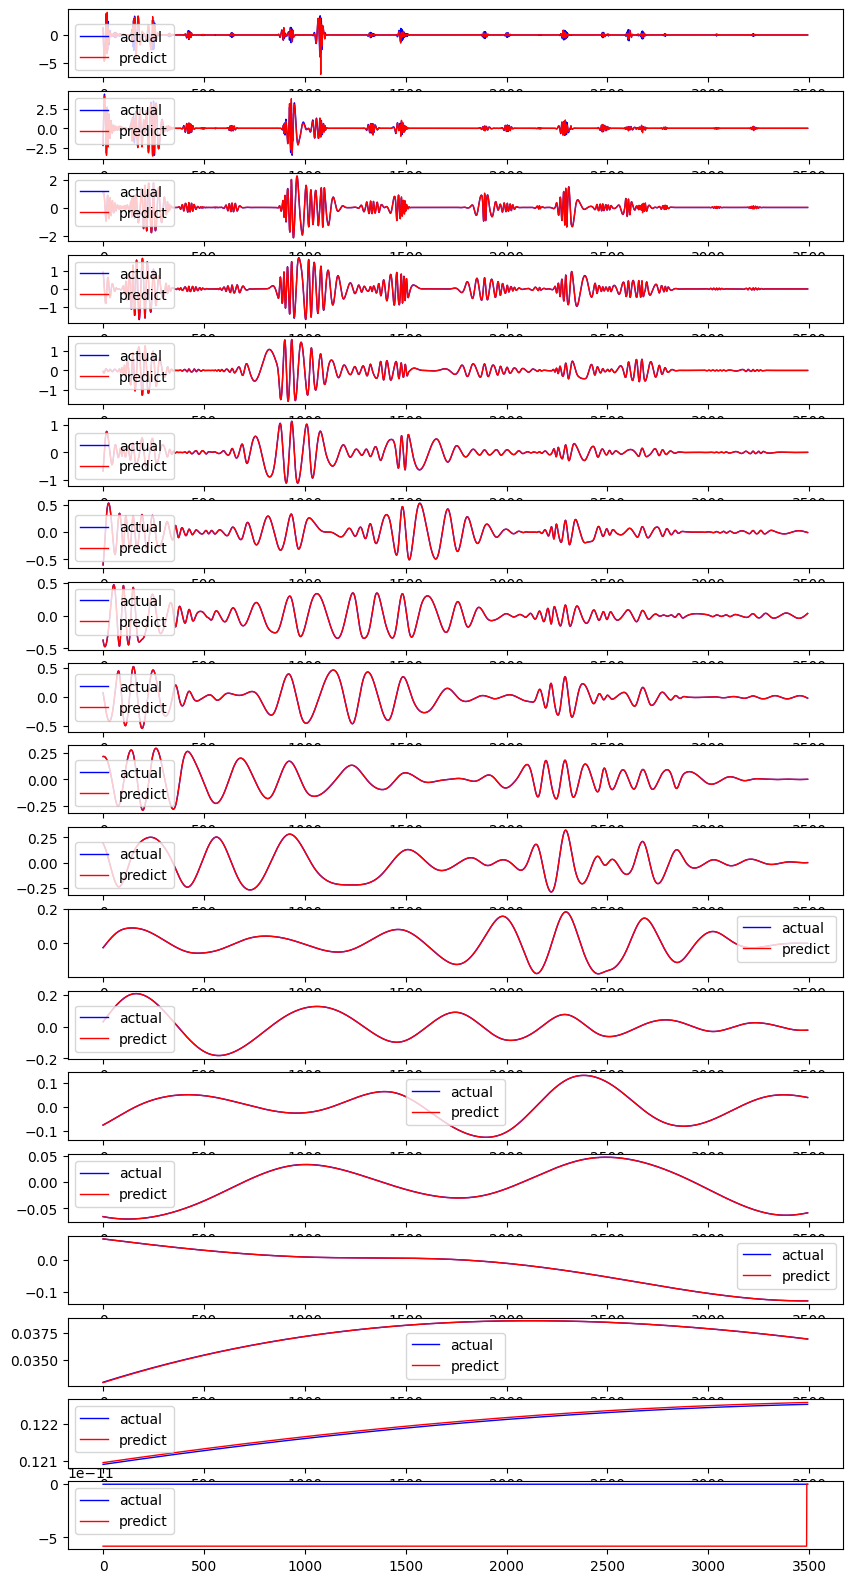

In [34]:
fig = plt.figure(figsize=(10,20))
for i,column in enumerate(decompose_data.columns):
    
    axes = fig.add_subplot(len(decompose_data.columns),1,i+1)
    axes.plot(y_test_list[i], 'b-',linewidth = '1', label='actual')
    axes.plot(y_pre_list[i], 'r-', linewidth = '1', label='predict')

    plt.legend()

In [36]:
#此时的预测是对全部分解结果的预测求和
y_pre_total = np.sum(np.array(y_pre_list),axis = 0).reshape(-1)
x_train_all,y_train_all,x_val_all, y_val_all,x_test_all, y_test_all = get_tain_val_test(X1,window_size)

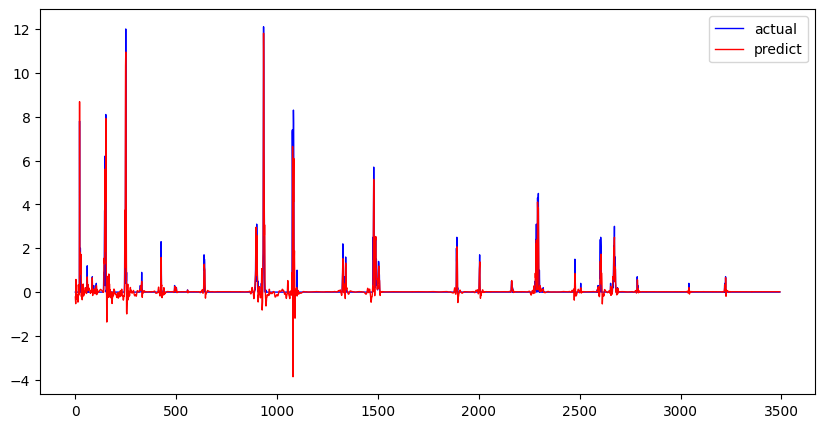

In [37]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [38]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [39]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.08865219669254172
MSE: 0.10371300190540829
HMAE: 0.7945893371044667
HMSE: 8.331815947941118
R^2: 0.762117272935589


In [40]:
# 将预测结果中小于0的值设置为0
y_pre_total[y_pre_total < 0] = 0

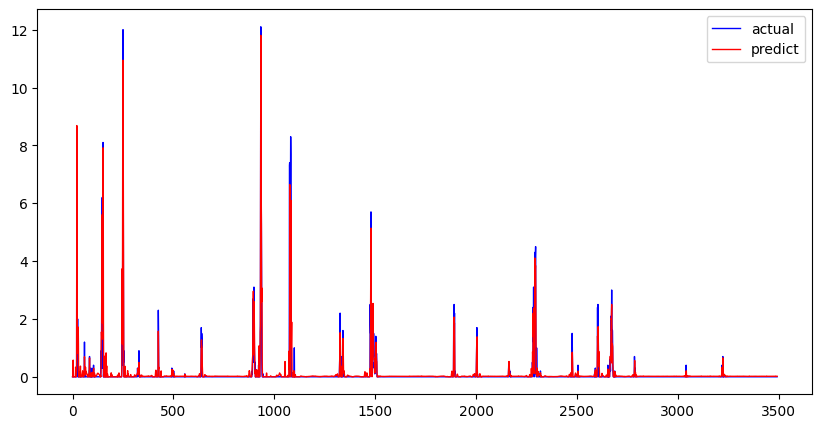

In [41]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [42]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [43]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.0690845489487822
MSE: 0.09336466491295761
HMAE: 0.5268101185656167
HMSE: 5.4291133110529195
R^2: 0.785852875792701


In [44]:
# import pandas as pd

# # 将 NumPy 数组转换为 DataFrame
# y_pre_total_df = pd.DataFrame(y_pre_total, columns=['Precipitation'])

# # 将 DataFrame 保存为 CSV 文件
# y_pre_total_df.to_csv('/private/数据/GRU-CEEMDANsydanreal.csv', index=False)

# 测试

In [453]:
dataset1 = list(range(1, 301))

In [454]:
len(dataset1)

300

In [455]:
dataset2 = pd.DataFrame(dataset1, columns=['Number'])

In [456]:
dataset3 = dataset2['Number']

In [457]:
dataset3 = dataset2['Number']

In [423]:
# 原划分定义函数
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


# 按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data, window_size):
    train_num = int(len(serie_data) * 0.7)
    val_num = int(len(serie_data) * 0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size = 0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行

    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造测试集
    x_test, y_test = TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size,
                                end_index=len(serie_data),
                                step=step, target_size=target_size, point_time=True, true=serie_data)
    return x_train, y_train, x_val, y_val, x_test, y_test



In [502]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


# 按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data, window_size, roll_step):
    train_num = int(len(serie_data) * 0.7)
    val_num = int(len(serie_data) * 0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size = 0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行
    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    
    # 构造滑动预测测试集
    x_test_l = []
    y_test_l = []
    for i in range(val_num, len(serie_data) - history_size, roll_step):
        start_index = i
        end_index = i + history_size + 1
        x_test_nu, y_test_nu = TimeSeries(dataset=serie_data, start_index=start_index, history_size=history_size, end_index =end_index,
                                          step=1, target_size=0, point_time=True, true=serie_data)
        x_test_nu = x_test_nu.tolist()
        y_test_nu = y_test_nu.tolist()
        x_test_l.extend(x_test_nu)
        y_test_l.extend(y_test_nu)
    x_test_r= np.array(x_test_l)
    y_test_r = np.array(y_test_l)
    # 构造测试集
    x_test, y_test = TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size,
                                end_index=len(serie_data),
                                step=step, target_size=target_size, point_time=True, true=serie_data)
    return x_train,y_train,x_val,y_val,x_test,y_test, x_test_r, y_test_r 




In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def recursive_prediction(model, test_data, steps):
    predictions = []
    for i in range(len(test_data)):
        current_input = test_data[i:i+1, :]  # 取出当前数据作为初始输入序列
        for _ in range(steps):
            # 使用模型进行单步预测
            prediction = model.predict(current_input)
            # 将预测结果添加到输入序列的末尾
            current_input = np.append(current_input[:, 1:], prediction, axis=1)
            predictions.append(prediction)
    return np.array(predictions)

In [503]:
import numpy as np
import pandas as pd

# 创建300个数值
x = np.linspace(0, 2 * np.pi, 300)

# 生成正弦、余弦和正切函数的值
sine_values = np.sin(x)
cosine_values = np.cos(x)
tangent_values = np.tan(x)

# 创建DataFrame
data = {
    'list1': sine_values,
    'list2': cosine_values,
    'list3': tangent_values
}

dataset = pd.DataFrame(data)

# 打印前几行数据
print(dataset.head())


      list1     list2     list3
0  0.000000  1.000000  0.000000
1  0.021012  0.999779  0.021017
2  0.042016  0.999117  0.042053
3  0.063000  0.998014  0.063126
4  0.083957  0.996469  0.084255


      list1     list2     list3
0  0.000000  1.000000  0.000000
1  0.021012  0.999779  0.021017
2  0.042016  0.999117  0.042053
3  0.063000  0.998014  0.063126
4  0.083957  0.996469  0.084255


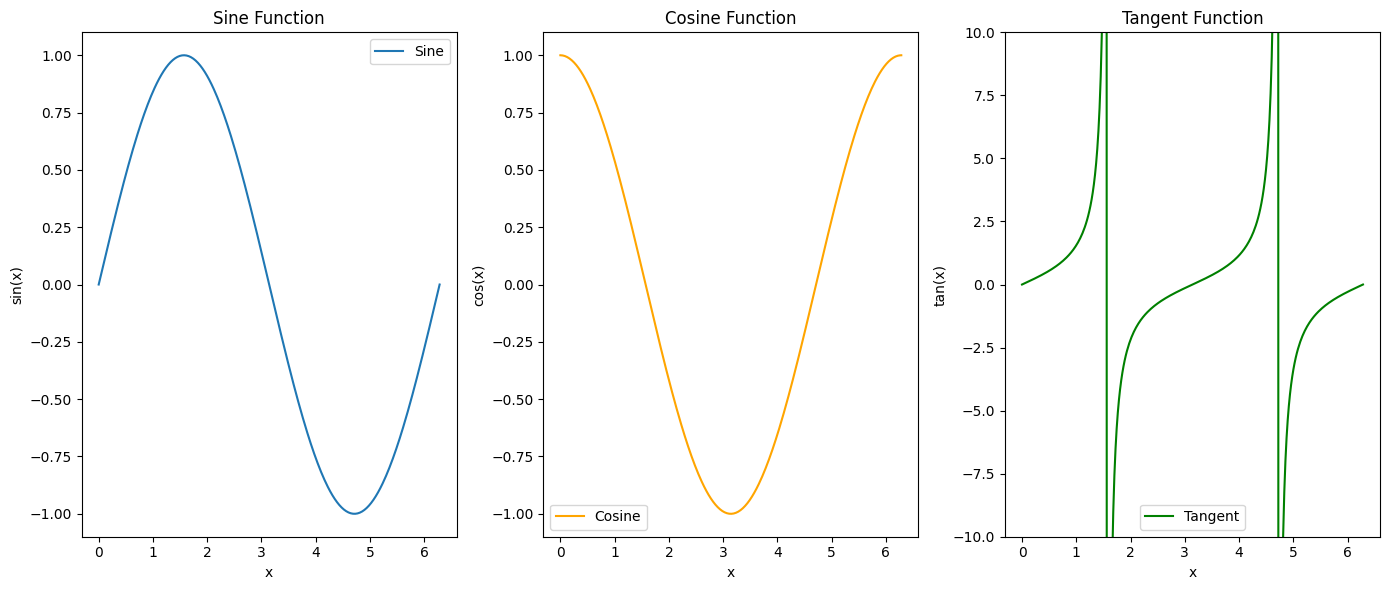

In [504]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建300个数值
x = np.linspace(0, 2 * np.pi, 300)

# 生成正弦、余弦和正切函数的值
sine_values = np.sin(x)
cosine_values = np.cos(x)
tangent_values = np.tan(x)

# 创建DataFrame
data = {
    'list1': sine_values,
    'list2': cosine_values,
    'list3': tangent_values
}

dataset = pd.DataFrame(data)

# 打印前几行数据
print(dataset.head())

# 绘制图形
plt.figure(figsize=(14, 6))

# 绘制正弦函数
plt.subplot(1, 3, 1)
plt.plot(x, sine_values, label='Sine')
plt.title('Sine Function')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()

# 绘制余弦函数
plt.subplot(1, 3, 2)
plt.plot(x, cosine_values, label='Cosine', color='orange')
plt.title('Cosine Function')
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.legend()

# 绘制正切函数
plt.subplot(1, 3, 3)
plt.plot(x, tangent_values, label='Tangent', color='green')
plt.title('Tangent Function')
plt.xlabel('x')
plt.ylabel('tan(x)')
plt.ylim(-10, 10)  # 限制y轴的范围以避免正切函数的发散
plt.legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [505]:
decompose_data = dataset

In [507]:
from tensorflow.keras.optimizers import Adam
# 模型定义和训练部分
y_pre_list = []
y_test_list = []
y_pre_recursive_list = []
window_size = 8
roll_steps = 4

for column in decompose_data.columns:
    serie_data = decompose_data[column]
    x_train, y_train, x_val, y_val, x_test, y_test, x_test_r, y_test_r = get_tain_val_test(serie_data, window_size, roll_steps)

    model = Sequential([
        GRU(50, input_shape=(window_size, 1), return_sequences=False),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=16, verbose=1)

    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)

    # 滑动递归预测
#     y_pred_recursive_all = []
#     for x_test_sample in x_test_r:
#         current_input = x_test_sample.reshape(1, window_size, 1)
#         y_pred_recursive = []
#         for _ in range(3):  # 递归预测3次
#             y_pred = model.predict(current_input)
#             y_pred_recursive.append(y_pred[0][0])
#             current_input = np.append(current_input[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)
#         y_pred_recursive_all.append(y_pred_recursive)

#     y_pre_recursive_list.append(y_pred_recursive_all)
#     y_test_list.append(y_test_r)  # 添加滑动预测的真实值

2024-05-19 16:46:16.783255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:46:16.784878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:46:16.786020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-19 16:46:20.422603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:46:20.424211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:46:20.425336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 9/13 [===================>..........] - ETA: 0s - loss: 0.2779 

2024-05-19 16:46:30.675709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:46:30.677595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:46:30.678642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 13s 667ms/step - loss: 0.2386 - val_loss: 0.3104
Epoch 2/20
13/13 [==============================] - 3s 209ms/step - loss: 0.0493 - val_loss: 0.0392
Epoch 3/20
13/13 [==============================] - 3s 209ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 4/20
13/13 [==============================] - 2s 128ms/step - loss: 0.0029 - val_loss: 0.0185
Epoch 5/20
13/13 [==============================] - 2s 165ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 6/20
13/13 [==============================] - 2s 127ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/20
13/13 [==============================] - 2s 165ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 8/20
13/13 [==============================] - 2s 166ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 9/20
13/13 [==============================] - 3s 252ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 10/20
13/13 [==============================] - 3s 250ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 11/

2024-05-19 16:47:19.210243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:47:19.211959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:47:19.213030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step


2024-05-19 16:47:20.740917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:47:20.742651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:47:20.743752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-19 16:47:26.251255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:47:26.252985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:47:26.254127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/13 [======================>.......] - ETA: 0s - loss: 0.2700 

2024-05-19 16:47:32.308715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:47:32.310368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:47:32.311583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 8s 321ms/step - loss: 0.2399 - val_loss: 0.1286
Epoch 2/20
13/13 [==============================] - 2s 167ms/step - loss: 0.0431 - val_loss: 0.0467
Epoch 3/20
13/13 [==============================] - 3s 250ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 4/20
13/13 [==============================] - 2s 128ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 5/20
13/13 [==============================] - 2s 164ms/step - loss: 0.0016 - val_loss: 0.0127
Epoch 6/20
13/13 [==============================] - 2s 167ms/step - loss: 0.0014 - val_loss: 0.0095
Epoch 7/20
13/13 [==============================] - 2s 169ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 8/20
13/13 [==============================] - 2s 165ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 9/20
13/13 [==============================] - 4s 293ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 10/20
13/13 [==============================] - 2s 125ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 11/2

2024-05-19 16:48:44.870483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:48:44.872387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:48:44.873440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 38s 38s/step


2024-05-19 16:48:52.968586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:48:52.970226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:48:52.971283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-19 16:49:05.021059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:49:05.022942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:49:05.024081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/13 [========================>.....] - ETA: 0s - loss: 45.2384  

2024-05-19 16:49:12.748752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:49:12.750543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:49:12.751597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 9s 447ms/step - loss: 219.1297 - val_loss: 840.3804
Epoch 2/20
13/13 [==============================] - 2s 167ms/step - loss: 216.3870 - val_loss: 836.5730
Epoch 3/20
13/13 [==============================] - 2s 168ms/step - loss: 214.8430 - val_loss: 831.8217
Epoch 4/20
13/13 [==============================] - 2s 167ms/step - loss: 213.8234 - val_loss: 827.7682
Epoch 5/20
13/13 [==============================] - 1s 124ms/step - loss: 212.5932 - val_loss: 824.9583
Epoch 6/20
13/13 [==============================] - 3s 251ms/step - loss: 211.6750 - val_loss: 822.1321
Epoch 7/20
13/13 [==============================] - 2s 167ms/step - loss: 210.5818 - val_loss: 816.9515
Epoch 8/20
13/13 [==============================] - 2s 167ms/step - loss: 209.4449 - val_loss: 814.2572
Epoch 9/20
13/13 [==============================] - 2s 168ms/step - loss: 208.8563 - val_loss: 803.7853
Epoch 10/20
13/13 [==============================] - 2s 166ms/step - loss: 

2024-05-19 16:49:54.618341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-19 16:49:54.620519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-19 16:49:54.621562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step


In [508]:
y_test_list

[array([-4.27109813e-01, -4.08016060e-01, -3.88742138e-01, -3.69296559e-01,
        -3.49687909e-01, -3.29924847e-01, -3.10016099e-01, -2.89970456e-01,
        -2.69796771e-01, -2.49503951e-01, -2.29100958e-01, -2.08596799e-01,
        -1.88000531e-01, -1.67321246e-01, -1.46568078e-01, -1.25750188e-01,
        -1.04876772e-01, -8.39570440e-02, -6.30002435e-02, -4.20156238e-02,
        -2.10124511e-02, -2.44929360e-16]),
 array([0.90419976, 0.91297475, 0.9213466 , 0.9293116 , 0.93686625,
        0.9440072 , 0.95073131, 0.9570356 , 0.96291729, 0.96837378,
        0.97340267, 0.97800173, 0.98216893, 0.98590243, 0.98920059,
        0.99206194, 0.99448523, 0.99646937, 0.99801351, 0.99911695,
        0.99977921, 1.        ]),
 array([-4.72362227e-01, -4.46908372e-01, -4.21928230e-01, -3.97387226e-01,
        -3.73252756e-01, -3.49493993e-01, -3.26081719e-01, -3.02988162e-01,
        -2.80186860e-01, -2.57652527e-01, -2.35360931e-01, -2.13288785e-01,
        -1.91413641e-01, -1.69713799e-01, 

In [509]:
window_size = 8
roll_steps = 4
serie_data = dataset3
x_train,y_train,x_val,y_val,x_test,y_test, x_test_r, y_test_r = get_tain_val_test(serie_data, window_size, roll_steps)

In [510]:
x_test_r.shape

(6, 8)

In [513]:
x_test_r

array([[271, 272, 273, 274, 275, 276, 277, 278],
       [275, 276, 277, 278, 279, 280, 281, 282],
       [279, 280, 281, 282, 283, 284, 285, 286],
       [283, 284, 285, 286, 287, 288, 289, 290],
       [287, 288, 289, 290, 291, 292, 293, 294],
       [291, 292, 293, 294, 295, 296, 297, 298]])

In [512]:
x_test

array([[271, 272, 273, 274, 275, 276, 277, 278],
       [272, 273, 274, 275, 276, 277, 278, 279],
       [273, 274, 275, 276, 277, 278, 279, 280],
       [274, 275, 276, 277, 278, 279, 280, 281],
       [275, 276, 277, 278, 279, 280, 281, 282],
       [276, 277, 278, 279, 280, 281, 282, 283],
       [277, 278, 279, 280, 281, 282, 283, 284],
       [278, 279, 280, 281, 282, 283, 284, 285],
       [279, 280, 281, 282, 283, 284, 285, 286],
       [280, 281, 282, 283, 284, 285, 286, 287],
       [281, 282, 283, 284, 285, 286, 287, 288],
       [282, 283, 284, 285, 286, 287, 288, 289],
       [283, 284, 285, 286, 287, 288, 289, 290],
       [284, 285, 286, 287, 288, 289, 290, 291],
       [285, 286, 287, 288, 289, 290, 291, 292],
       [286, 287, 288, 289, 290, 291, 292, 293],
       [287, 288, 289, 290, 291, 292, 293, 294],
       [288, 289, 290, 291, 292, 293, 294, 295],
       [289, 290, 291, 292, 293, 294, 295, 296],
       [290, 291, 292, 293, 294, 295, 296, 297],
       [291, 292, 29

In [533]:
# 原始版本
#定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


#按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data,window_size):
    train_num = int(len(serie_data)*0.7)
    val_num = int(len(serie_data)*0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size =  0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行

    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造测试集
    x_test, y_test =  TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size, end_index=len(serie_data),
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 查看数据集信息
    #print('x_train_shape:', x_train.shape)
    #print('y_train_shape:', y_train.shape)
    return x_train,y_train,x_val, y_val,x_test, y_test


import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def implement_LSTM(X_train, y_train,X_validate,y_validate,verbose = 0, model_summary = False):
    model = Sequential()
    model.add(LSTM(30, input_shape=(None,1)))
    model.add(Dense(1))
    if model_summary:
        model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_squared_error', optimizer='sgd')
    history = model.fit(X_train, y_train, epochs=20,validation_data=(X_validate,y_validate), batch_size=16, verbose=verbose)
    print('finished training')
    return history,model

In [534]:
window_size = 8
serie_data = dataset3
x_train_all,y_train_all,x_val_all, y_val_all,x_test_all, y_test_all = get_tain_val_test(serie_data,window_size)

In [535]:
history,model = implement_LSTM(x_train_all, y_train_all, x_val_all, y_val_all)

2024-05-20 15:23:44.780366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 15:23:44.781947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 15:23:44.783011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

finished training


In [524]:
y_pre_all = model.predict(x_test_all).reshape(-1)

1/1 [==============================] - 0s 309ms/step


2024-05-20 15:06:44.111364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 15:06:44.113120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 15:06:44.114214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [530]:
y_pre_all = model.predict(x_test_all)

1/1 [==============================] - 2s 2s/step


In [538]:
array_2d = np.array([
    [1, 2, 3,1, 2, 3,1,2]
])

In [539]:
y_pre_all = model.predict(array_2d)

2024-05-20 15:50:46.453473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 15:50:46.455111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 15:50:46.456099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 625ms/step


In [542]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def recursive_prediction(model, test_data, steps):
    predictions = []
    for i in range(len(test_data)):
        current_input = test_data[i:i+1, :]  # 取出当前数据作为初始输入序列
        for _ in range(steps):
            # 使用模型进行单步预测
            prediction = model.predict(current_input)
            # 将预测结果添加到输入序列的末尾
            current_input = np.append(current_input[:, 1:], prediction, axis=1)
            predictions.append(prediction)
    return np.array(predictions)

# 创建模型
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(30, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# 使用例子
# 假设 test_r 是你的测试数据，形状为 (样本数, 时间步长)
# 假设我们要预测 3 步
test_data = test_r
input_shape = (None, test_data.shape[1])  # 输入形状为 (None, 时间步长)
model = create_model(input_shape)
# 训练模型
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
# 递归预测
steps = 3  # 需要预测的步数
predictions = recursive_prediction(model, test_data, steps)


array([[12.779311]], dtype=float32)

In [529]:
y_pre_deal = y_pre_all.reshape(-1)
y_pre_deal

array([12.085555 , 12.085557 , 12.085558 , 12.08556  , 12.085562 ,
       12.085563 , 12.085564 , 12.085566 , 12.0855665, 12.085567 ,
       12.085569 , 12.085571 , 12.085571 , 12.085573 , 12.085574 ,
       12.085575 , 12.085577 , 12.085577 , 12.085579 , 12.08558  ,
       12.085581 , 12.085582 ], dtype=float32)

In [532]:
x_test_all

array([[271, 272, 273, 274, 275, 276, 277, 278],
       [272, 273, 274, 275, 276, 277, 278, 279],
       [273, 274, 275, 276, 277, 278, 279, 280],
       [274, 275, 276, 277, 278, 279, 280, 281],
       [275, 276, 277, 278, 279, 280, 281, 282],
       [276, 277, 278, 279, 280, 281, 282, 283],
       [277, 278, 279, 280, 281, 282, 283, 284],
       [278, 279, 280, 281, 282, 283, 284, 285],
       [279, 280, 281, 282, 283, 284, 285, 286],
       [280, 281, 282, 283, 284, 285, 286, 287],
       [281, 282, 283, 284, 285, 286, 287, 288],
       [282, 283, 284, 285, 286, 287, 288, 289],
       [283, 284, 285, 286, 287, 288, 289, 290],
       [284, 285, 286, 287, 288, 289, 290, 291],
       [285, 286, 287, 288, 289, 290, 291, 292],
       [286, 287, 288, 289, 290, 291, 292, 293],
       [287, 288, 289, 290, 291, 292, 293, 294],
       [288, 289, 290, 291, 292, 293, 294, 295],
       [289, 290, 291, 292, 293, 294, 295, 296],
       [290, 291, 292, 293, 294, 295, 296, 297],
       [291, 292, 29

In [540]:
y_test_r

array([279, 283, 287, 291, 295, 299])

In [541]:
x_train_all.shape

(202, 8)

In [465]:
y_val

array([219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270])

In [466]:
x_train

array([[  1,   2,   3, ...,   6,   7,   8],
       [  2,   3,   4, ...,   7,   8,   9],
       [  3,   4,   5, ...,   8,   9,  10],
       ...,
       [200, 201, 202, ..., 205, 206, 207],
       [201, 202, 203, ..., 206, 207, 208],
       [202, 203, 204, ..., 207, 208, 209]])

In [467]:
y_train

array([  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [528]:
input_shape = model.input_shape
input_shape

(None, None, 1)

In [469]:
y_test_r

array([279, 283, 287, 291, 295, 299])

# 完整多步预测的代码

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


# 按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data, window_size, roll_step):
    train_num = int(len(serie_data) * 0.7)
    val_num = int(len(serie_data) * 0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size = 0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行
    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    
    # 构造滑动预测测试集
    x_test_l = []
    y_test_l = []
    for i in range(val_num, len(serie_data) - history_size, roll_step):
        start_index = i
        end_index = i + history_size + 1
        x_test_nu, y_test_nu = TimeSeries(dataset=serie_data, start_index=start_index, history_size=history_size, end_index =end_index,
                                          step=1, target_size=0, point_time=True, true=serie_data)
        x_test_nu = x_test_nu.tolist()
        y_test_nu = y_test_nu.tolist()
        x_test_l.extend(x_test_nu)
        y_test_l.extend(y_test_nu)
    x_test_r= np.array(x_test_l)
    y_test_r = np.array(y_test_l)
    # 构造测试集
    x_test, y_test = TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size,
                                end_index=len(serie_data),
                                step=step, target_size=target_size, point_time=True, true=serie_data)
    return x_train,y_train,x_val,y_val,x_test,y_test, x_test_r, y_test_r 




In [ ]:
# 滑动预测函数
from keras.models import Sequential
from keras.layers import LSTM, Dense

def recursive_prediction(model, test_data, steps):
    predictions = []
    for i in range(len(test_data)):
        current_input = test_data[i:i+1, :]  # 取出当前数据作为初始输入序列
        for _ in range(steps):
            # 使用模型进行单步预测
            prediction = model.predict(current_input, verbose=0)
            # 将预测结果添加到输入序列的末尾
            current_input = np.append(current_input[:, 1:], prediction, axis=1)
            predictions.append(prediction)
    return np.array(predictions)

In [ ]:
# 模型定义函数
def implement_LSTM(X_train, y_train,X_validate,y_validate,verbose = 0, model_summary = False):
    model = Sequential()
    model.add(LSTM(50, input_shape=(None,1)))
    model.add(Dense(1))
    if model_summary:
        model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_squared_error', optimizer='sgd')
    history = model.fit(X_train, y_train, epochs=20,validation_data=(X_validate,y_validate), batch_size=16, verbose=verbose)
    print('finished training')
    return history,model

In [ ]:
# 滑动预测与普通预测
y_pre_list = []
y_test_list = []
y_pre_r_list = []
window_size = 8
roll_step = 3
for column in decompose_data.columns:
    serie_data = decompose_data[column]
    x_train,y_train,x_val, y_val,x_test, y_test, x_test_r, y_test_r = get_tain_val_test(serie_data,window_size, roll_step)
    history,model = implement_LSTM(x_train, y_train, x_val, y_val)
    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)
    test_data = x_test_r
    steps = 3
    model = model
    y_pre_r = recursive_prediction(model, test_data, steps)
    y_pre_r_list.append(y_pre_r)

In [ ]:
# 多步预测结果划分
# 假设 predictions 是你现有的列表
y_pre_r_list1 = []

for sublist in y_pre_r_list:
    # 每个 sublist 是一个 (24, 1, 1) 的数组
    # 我们需要去掉中间的 1，然后 flatten
    formatted_array = sublist.reshape(-1, 1)
    y_pre_r_list1.append(formatted_array)


# EMD分解

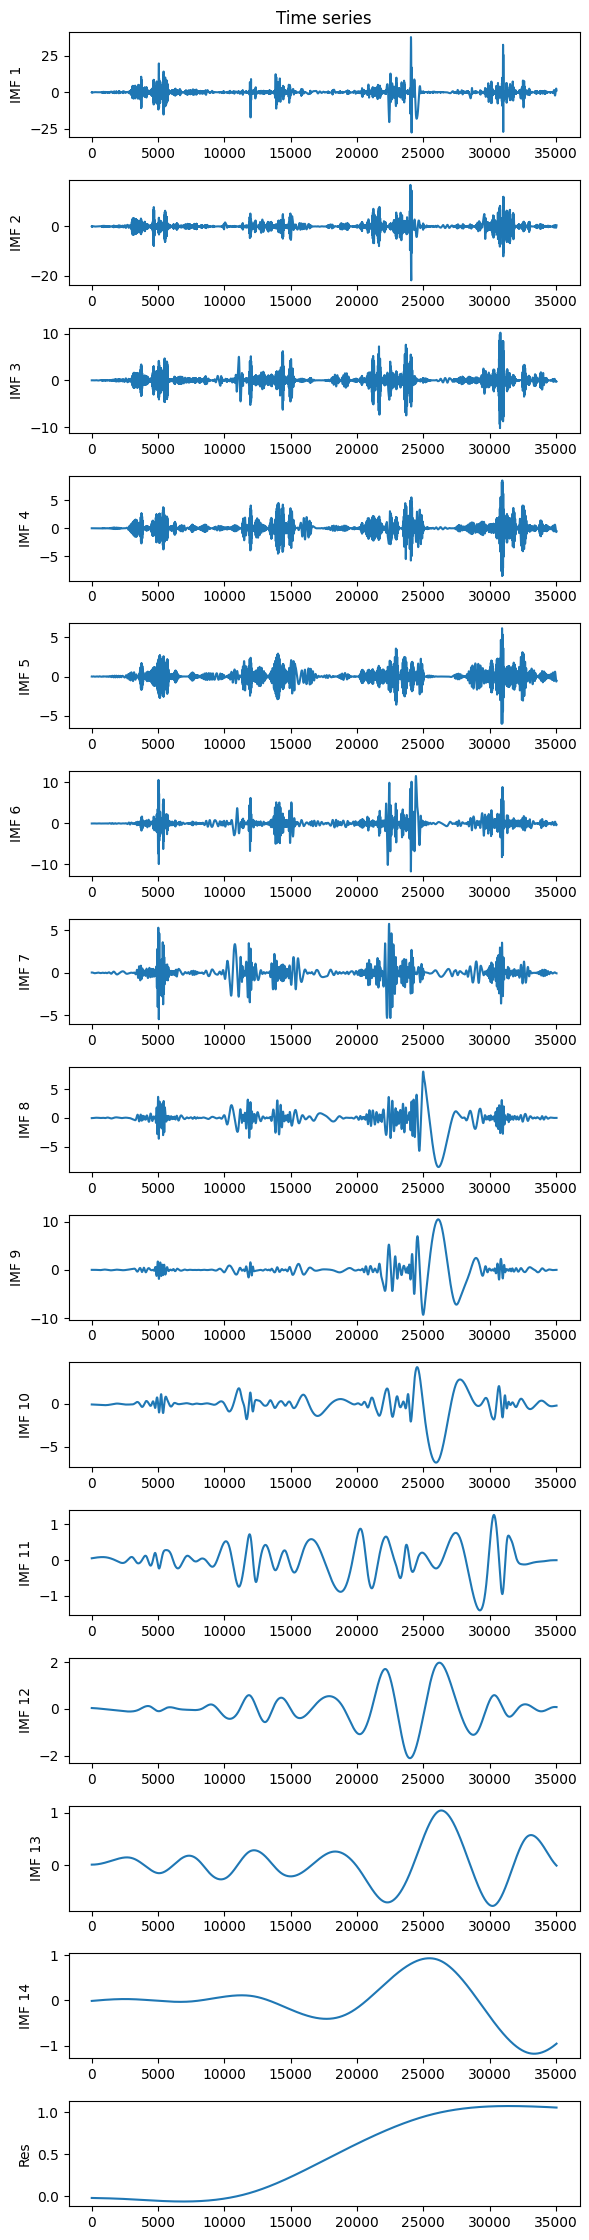

In [31]:
from PyEMD import EMD
import numpy as np

emd = EMD()
emd.emd(X1.values.reshape(-1))
imfs_close1, res_close1 = emd.get_imfs_and_residue()

t = np.arange(0, len(X1), 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close1, residue=res_close1, t=t, include_residue=True)
vis.show()


In [32]:
decompose_data1 = pd.DataFrame(np.vstack((imfs_close1, res_close1)).T,columns = ['IMF%d'%(i+1) for i in range(len(imfs_close1))] + ['Res'])

In [33]:
decompose_data1

IMF1      IMF2      IMF3      IMF4      IMF5      IMF6      IMF7  \
0      0.037351 -0.039715 -0.000300  0.002030 -0.000519 -0.006018  0.039726   
1      0.065914 -0.068114 -0.000531  0.002030 -0.001179 -0.005508  0.039924   
2      0.085858 -0.087921 -0.000709  0.002004 -0.001827 -0.005008  0.040117   
3      0.096752 -0.098706 -0.000833  0.001952 -0.002464 -0.004518  0.040304   
4      0.098167 -0.100042 -0.000900  0.001872 -0.003088 -0.004038  0.040485   
...         ...       ...       ...       ...       ...       ...       ...   
35037  1.588036  0.260460 -0.264885 -0.588260 -0.584825 -0.334219 -0.055281   
35038  1.506460  0.306970 -0.263328 -0.575576 -0.575485 -0.322606 -0.055356   
35039  1.421487  0.355091 -0.261858 -0.562190 -0.565548 -0.310443 -0.055406   
35040  1.333117  0.404851 -0.260462 -0.548119 -0.555025 -0.297738 -0.055431   
35041  1.241349  0.456278 -0.259125 -0.533383 -0.543928 -0.284501 -0.055432   

           IMF8      IMF9     IMF10     IMF11     IMF12     IMF13     IMF14  \
0     -0.037495  0.015155 -0.072360  0.049286  0.033411  0.014719 -0.013315   
1     -0.037506  0.015214 -0.072449  0.049349  0.033387  0.014718 -0.013289   
2     -0.037514  0.015273 -0.072539  0.049413  0.033362  0.014717 -0.013262   
3     -0.037519  0.015332 -0.072628  0.049476  0.033338  0.014716 -0.013236   
4     -0.037521  0.015392 -0.072718  0.049540  0.033313  0.014715 -0.013209   
...         ...       ...       ...       ...       ...       ...       ...   
35037 -0.000682  0.018129 -0.202467 -0.004524  0.074323 -0.002735 -0.958205   
35038 -0.000674  0.017966 -0.202273 -0.004519  0.074248 -0.002992 -0.957959   
35039 -0.000665  0.017798 -0.202080 -0.004514  0.074173 -0.003249 -0.957713   
35040 -0.000654  0.017626 -0.201888 -0.004509  0.074097 -0.003505 -0.957466   
35041 -0.000642  0.017450 -0.201697 -0.004504  0.074020 -0.003762 -0.957220   

            Res  
0     -0.021957  
1     -0.021960  
2     -0.021963  
3     -0.021965  
4     -0.021968  
...         ...  
35037  1.055133  
35038  1.055124  
35039  1.055115  
35040  1.055106  
35041  1.055096  

[35042 rows x 15 columns]

In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.callbacks import EarlyStopping

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


# 按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data, window_size):
    train_num = int(len(serie_data) * 0.7)
    val_num = int(len(serie_data) * 0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size = 0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行

    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造测试集
    x_test, y_test = TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size,
                                end_index=len(serie_data),
                                step=step, target_size=target_size, point_time=True, true=serie_data)
    return x_train, y_train, x_val, y_val, x_test, y_test




# EMD-GRU

In [57]:
from tensorflow.keras.optimizers import Adam

y_pre_list = []
y_test_list = []
window_size = 12

for column in decompose_data1.columns:
    serie_data = decompose_data1[column]
    x_train, y_train, x_val, y_val, x_test, y_test = get_tain_val_test(serie_data, window_size)
    
    # 在每次循环开始时重新实例化模型
    model = Sequential([
        GRU(50, input_shape=(window_size, 1), return_sequences=False),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=16, verbose=1)
    
    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)

# 这里可以添加代码以评估模型性能，比如计算每一列的MSE或MAE

2024-05-16 10:42:34.423895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:42:34.425728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:42:34.426811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 10:42:36.163688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:42:36.165351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:42:36.166471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1527/1533 [============================>.] - ETA: 0s - loss: 1.8412

2024-05-16 10:42:46.317700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:42:46.319242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:42:46.320298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 12s 7ms/step - loss: 1.8365 - val_loss: 1.0662
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.8130 - val_loss: 0.8439
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.6361 - val_loss: 0.7941
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.5612 - val_loss: 0.7504
Epoch 5/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.5140 - val_loss: 0.7242
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.5084 - val_loss: 0.7078
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.4743 - val_loss: 0.7482
Epoch 8/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.4604 - val_loss: 0.6792
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.4263 - val_loss: 0.7238
Epoch 10/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.4110 

2024-05-16 10:45:55.096249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:45:55.097935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:45:55.098993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 10:45:58.086621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:45:58.088460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:45:58.089489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 10:45:59.282186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:45:59.283863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:45:59.285010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1525/1533 [============================>.] - ETA: 0s - loss: 0.4429

2024-05-16 10:46:10.480340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:46:10.481937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:46:10.482990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 13s 6ms/step - loss: 0.4410 - val_loss: 0.1177
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0885 - val_loss: 0.0910
Epoch 3/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0675 - val_loss: 0.0813
Epoch 4/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0563 - val_loss: 0.0717
Epoch 5/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0500 - val_loss: 0.0808
Epoch 6/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0451 - val_loss: 0.0789
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0418 - val_loss: 0.0685
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0395 - val_loss: 0.0698
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0381 - val_loss: 0.0600
Epoch 10/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0350 -

2024-05-16 10:49:19.433948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:49:19.435677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:49:19.436765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 10:49:22.632995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:49:22.634686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:49:22.635736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 10:49:23.046130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:49:23.047766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:49:23.048897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 0.0790

2024-05-16 10:49:33.058980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:49:33.060549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:49:33.061605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 12s 7ms/step - loss: 0.0786 - val_loss: 0.0224
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0066 - val_loss: 0.0109
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0030 - val_loss: 0.0113
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 10/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0030

2024-05-16 10:52:41.155917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:52:41.157195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:52:41.158517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step
Epoch 1/20


2024-05-16 10:52:44.309236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:52:44.310984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:52:44.311976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1527/1533 [============================>.] - ETA: 0s - loss: 0.0250

2024-05-16 10:52:55.080759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:52:55.082375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:52:55.083455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 12s 7ms/step - loss: 0.0249 - val_loss: 0.0066
Epoch 2/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 3/20
1533/1533 [==============================] - 11s 7ms/step - loss: 8.6386e-04 - val_loss: 0.0017
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.8026e-04 - val_loss: 0.0013
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 4.1670e-04 - val_loss: 0.0011
Epoch 6/20
1533/1533 [==============================] - 9s 6ms/step - loss: 3.7060e-04 - val_loss: 6.4323e-04
Epoch 7/20
1533/1533 [==============================] - 10s 7ms/step - loss: 4.3891e-04 - val_loss: 6.8703e-04
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 3.1989e-04 - val_loss: 7.1616e-04
Epoch 9/20
1533/1533 [==============================] - 9s 6ms/step - loss: 3.6810e-04 - val_loss: 9.4938e-04
Epoch 10/20
1533/1533 [===================

2024-05-16 10:56:03.585119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:56:03.586425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:56:03.587750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 10:56:06.770484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:56:06.772535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:56:06.775111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 10:56:08.809777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:56:08.811498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:56:08.812621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1532/1533 [============================>.] - ETA: 0s - loss: 0.0118

2024-05-16 10:56:18.850973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:56:18.853092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:56:18.854152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 12s 6ms/step - loss: 0.0118 - val_loss: 0.0035
Epoch 2/20
1533/1533 [==============================] - 11s 7ms/step - loss: 9.0843e-04 - val_loss: 0.0011
Epoch 3/20
1533/1533 [==============================] - 11s 7ms/step - loss: 3.4617e-04 - val_loss: 3.6475e-04
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.8216e-04 - val_loss: 2.4156e-04
Epoch 5/20
1533/1533 [==============================] - 10s 7ms/step - loss: 1.3330e-04 - val_loss: 2.0796e-04
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 9.3732e-05 - val_loss: 1.0975e-04
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 7.6481e-05 - val_loss: 1.1318e-04
Epoch 8/20
1533/1533 [==============================] - 15s 10ms/step - loss: 6.3870e-05 - val_loss: 1.2607e-04
Epoch 9/20
1533/1533 [==============================] - 10s 7ms/step - loss: 5.5066e-05 - val_loss: 3.4139e-04
Epoch 10/20
1533/1533 [

2024-05-16 10:59:38.236501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:59:38.237813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:59:38.239280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 2s 3ms/step


2024-05-16 10:59:42.815136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:59:42.816888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:59:42.817942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 10:59:44.107199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:59:44.108811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:59:44.109948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1525/1533 [============================>.] - ETA: 0s - loss: 0.0886

2024-05-16 10:59:56.565524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 10:59:56.567357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 10:59:56.568399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 15s 9ms/step - loss: 0.0882 - val_loss: 0.0011
Epoch 2/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0029 - val_loss: 4.5712e-04
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0022 - val_loss: 3.9699e-04
Epoch 4/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0011 - val_loss: 5.3175e-04
Epoch 5/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0010 - val_loss: 1.6295e-04
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 9.0712e-04 - val_loss: 9.4003e-05
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 3.6951e-04 - val_loss: 1.8300e-04
Epoch 8/20
1533/1533 [==============================] - 11s 7ms/step - loss: 4.8217e-04 - val_loss: 3.0548e-04
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.2893e-04 - val_loss: 3.4217e-05
Epoch 10/20
1533/1533 [==============

2024-05-16 11:03:11.777544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:03:11.779128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:03:11.780186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step
Epoch 1/20


2024-05-16 11:03:14.953863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:03:14.955521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:03:14.956552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1531/1533 [============================>.] - ETA: 0s - loss: 0.0151

2024-05-16 11:03:25.028611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:03:25.030228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:03:25.031281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 11s 6ms/step - loss: 0.0151 - val_loss: 2.2372e-04
Epoch 2/20
1533/1533 [==============================] - 10s 7ms/step - loss: 5.1119e-04 - val_loss: 1.6043e-04
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 2.7088e-04 - val_loss: 6.1748e-04
Epoch 4/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.9145e-04 - val_loss: 1.2792e-05
Epoch 5/20
1533/1533 [==============================] - 9s 6ms/step - loss: 2.6922e-04 - val_loss: 8.2509e-06
Epoch 6/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.3797e-04 - val_loss: 1.1476e-05
Epoch 7/20
1533/1533 [==============================] - 9s 6ms/step - loss: 1.2422e-04 - val_loss: 7.9054e-05
Epoch 8/20
1533/1533 [==============================] - 10s 7ms/step - loss: 9.7502e-05 - val_loss: 9.9573e-05
Epoch 9/20
1533/1533 [==============================] - 11s 7ms/step - loss: 8.7220e-05 - val_loss: 2.0658e-05
Epoch 10/20
1533/15

2024-05-16 11:06:55.178563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:06:55.180342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:06:55.181422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 3s 3ms/step


2024-05-16 11:06:59.583442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:06:59.585108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:06:59.586128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 11:07:02.228214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:07:02.229916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:07:02.231074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1530/1533 [============================>.] - ETA: 0s - loss: 0.0098

2024-05-16 11:07:14.383018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:07:14.384805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:07:14.385839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 14s 8ms/step - loss: 0.0098 - val_loss: 0.2622
Epoch 2/20
1533/1533 [==============================] - 10s 7ms/step - loss: 8.1594e-05 - val_loss: 0.1798
Epoch 3/20
1533/1533 [==============================] - 11s 7ms/step - loss: 8.9075e-05 - val_loss: 0.1357
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 6.5137e-05 - val_loss: 0.0997
Epoch 5/20
1533/1533 [==============================] - 11s 7ms/step - loss: 7.8976e-05 - val_loss: 0.0669
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.3504e-05 - val_loss: 0.0559
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.8047e-05 - val_loss: 0.0672
Epoch 8/20
1533/1533 [==============================] - 10s 7ms/step - loss: 7.4819e-05 - val_loss: 0.0430
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 8.9466e-05 - val_loss: 0.0643
Epoch 10/20
1533/1533 [=============================

2024-05-16 11:10:36.185805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:10:36.187467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:10:36.188489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 11:10:39.326183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:10:39.327477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:10:39.328820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 11:10:41.226662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:10:41.228327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:10:41.229444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1531/1533 [============================>.] - ETA: 0s - loss: 0.0157

2024-05-16 11:10:53.106984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:10:53.108309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:10:53.109693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 13s 7ms/step - loss: 0.0157 - val_loss: 0.6344
Epoch 2/20
1533/1533 [==============================] - 11s 7ms/step - loss: 2.2050e-04 - val_loss: 0.4593
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.8490e-04 - val_loss: 0.3068
Epoch 4/20
1533/1533 [==============================] - 10s 7ms/step - loss: 2.8484e-04 - val_loss: 0.2093
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 3.4577e-04 - val_loss: 0.2931
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 8.8008e-05 - val_loss: 0.1274
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.5222e-04 - val_loss: 0.1143
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.0794e-04 - val_loss: 0.1067
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 7.4018e-05 - val_loss: 0.0922
Epoch 10/20
1533/1533 [=============================

2024-05-16 11:14:10.698321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:14:10.700109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:14:10.701129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 2s 3ms/step
Epoch 1/20


2024-05-16 11:14:14.077454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:14:14.079113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:14:14.080173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1531/1533 [============================>.] - ETA: 0s - loss: 0.0037

2024-05-16 11:14:27.087134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:14:27.088907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:14:27.089961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 14s 8ms/step - loss: 0.0037 - val_loss: 0.7024
Epoch 2/20
1533/1533 [==============================] - 10s 7ms/step - loss: 3.7336e-05 - val_loss: 0.4293
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 4.8617e-05 - val_loss: 0.3258
Epoch 4/20
1533/1533 [==============================] - 11s 7ms/step - loss: 7.2505e-05 - val_loss: 0.2454
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.0388e-04 - val_loss: 0.2257
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 7.7389e-06 - val_loss: 0.0690
Epoch 7/20
1533/1533 [==============================] - 9s 6ms/step - loss: 3.2107e-05 - val_loss: 0.1162
Epoch 8/20
1533/1533 [==============================] - 9s 6ms/step - loss: 1.7319e-05 - val_loss: 0.0744
Epoch 9/20
1533/1533 [==============================] - 11s 7ms/step - loss: 2.4879e-05 - val_loss: 0.0765
Epoch 10/20
1533/1533 [==============================]

2024-05-16 11:17:40.405377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:17:40.407078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:17:40.408121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 2s 3ms/step
Epoch 1/20


2024-05-16 11:17:44.361395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:17:44.363098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:17:44.364129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1529/1533 [============================>.] - ETA: 0s - loss: 8.8087e-04

2024-05-16 11:17:54.371251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:17:54.373070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:17:54.374117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 11s 6ms/step - loss: 8.7902e-04 - val_loss: 2.3987e-04
Epoch 2/20
1533/1533 [==============================] - 9s 6ms/step - loss: 1.3907e-05 - val_loss: 3.9068e-05
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 7.3962e-06 - val_loss: 1.3153e-05
Epoch 4/20
1533/1533 [==============================] - 9s 6ms/step - loss: 5.5955e-06 - val_loss: 7.3390e-06
Epoch 5/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.6082e-06 - val_loss: 1.1824e-05
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.4355e-06 - val_loss: 2.7016e-06
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 3.7204e-06 - val_loss: 9.3919e-07
Epoch 8/20
1533/1533 [==============================] - 9s 6ms/step - loss: 2.2009e-06 - val_loss: 4.2098e-06
Epoch 9/20
1533/1533 [==============================] - 9s 6ms/step - loss: 3.3576e-07 - val_loss: 3.3741e-06
Epoch 10/20
1533/

2024-05-16 11:21:05.361733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:21:05.363070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:21:05.364393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 11:21:08.419314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:21:08.421014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:21:08.422055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 11:21:11.594004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:21:11.595764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:21:11.596907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1524/1533 [============================>.] - ETA: 0s - loss: 0.0030

2024-05-16 11:21:22.395568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:21:22.397350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:21:22.398357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 13s 7ms/step - loss: 0.0030 - val_loss: 4.2636e-05
Epoch 2/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.0378e-05 - val_loss: 7.0810e-05
Epoch 3/20
1533/1533 [==============================] - 10s 7ms/step - loss: 2.0279e-05 - val_loss: 3.1940e-05
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.8612e-05 - val_loss: 3.5323e-05
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.3181e-05 - val_loss: 1.3023e-05
Epoch 6/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.4161e-05 - val_loss: 5.7145e-06
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.0687e-05 - val_loss: 1.5354e-05
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.7810e-05 - val_loss: 5.4611e-06
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.1771e-06 - val_loss: 7.3371e-06
Epoch 10/20
1533

2024-05-16 11:24:36.520925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:24:36.522234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:24:36.523566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 11:24:39.684280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:24:39.686063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:24:39.687110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 11:24:42.355233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:24:42.356549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:24:42.357974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - ETA: 0s - loss: 3.6777e-04

2024-05-16 11:24:54.619749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:24:54.621437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:24:54.622513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 14s 7ms/step - loss: 3.6777e-04 - val_loss: 5.2420e-04
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.3719e-06 - val_loss: 3.5265e-04
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.9921e-06 - val_loss: 3.0154e-04
Epoch 4/20
1533/1533 [==============================] - 14s 9ms/step - loss: 2.5516e-06 - val_loss: 1.2108e-04
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.8796e-06 - val_loss: 5.4694e-05
Epoch 6/20
1533/1533 [==============================] - 9s 6ms/step - loss: 2.4783e-06 - val_loss: 3.8034e-05
Epoch 7/20
1533/1533 [==============================] - 10s 7ms/step - loss: 1.9109e-06 - val_loss: 3.9594e-05
Epoch 8/20
1533/1533 [==============================] - 10s 6ms/step - loss: 5.7014e-07 - val_loss: 9.8170e-06
Epoch 9/20
1533/1533 [==============================] - 10s 6ms/step - loss: 9.1466e-07 - val_loss: 1.3332e-06
Epoch 10/20
1

2024-05-16 11:28:05.130229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:28:05.131886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:28:05.132940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step
Epoch 1/20


2024-05-16 11:28:08.348255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:28:08.349895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:28:08.350942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1529/1533 [============================>.] - ETA: 0s - loss: 3.4985e-04

2024-05-16 11:28:18.419368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:28:18.420900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:28:18.421962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 11s 6ms/step - loss: 3.4909e-04 - val_loss: 6.4391e-05
Epoch 2/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.7181e-06 - val_loss: 3.1592e-05
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.1802e-06 - val_loss: 3.4189e-05
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 2.3119e-06 - val_loss: 2.7016e-05
Epoch 5/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.9798e-06 - val_loss: 4.1718e-06
Epoch 6/20
1533/1533 [==============================] - 10s 6ms/step - loss: 3.3054e-06 - val_loss: 5.0776e-06
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 6.3094e-07 - val_loss: 7.2094e-06
Epoch 8/20
1533/1533 [==============================] - 11s 7ms/step - loss: 1.6383e-06 - val_loss: 3.4003e-06
Epoch 9/20
1533/1533 [==============================] - 10s 7ms/step - loss: 7.1340e-07 - val_loss: 4.1128e-06
Epoch 10/20


2024-05-16 11:31:29.478641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:31:29.480389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:31:29.481465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 1s 3ms/step


2024-05-16 11:31:32.625163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:31:32.627071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:31:32.628095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-05-16 11:31:33.483712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:31:33.485408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:31:33.486491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1526/1533 [============================>.] - ETA: 0s - loss: 0.0012

2024-05-16 11:31:43.790222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:31:43.792030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:31:43.793094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1533/1533 [==============================] - 12s 7ms/step - loss: 0.0012 - val_loss: 1.3133e-04
Epoch 2/20
1533/1533 [==============================] - 9s 6ms/step - loss: 1.7491e-06 - val_loss: 9.5354e-05
Epoch 3/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.5284e-06 - val_loss: 5.1033e-05
Epoch 4/20
1533/1533 [==============================] - 10s 6ms/step - loss: 1.9816e-06 - val_loss: 6.6817e-06
Epoch 5/20
1533/1533 [==============================] - 9s 6ms/step - loss: 2.1178e-06 - val_loss: 1.9684e-06
Epoch 6/20
1533/1533 [==============================] - 10s 7ms/step - loss: 1.9256e-06 - val_loss: 5.5264e-07
Epoch 7/20
1533/1533 [==============================] - 10s 6ms/step - loss: 3.0300e-06 - val_loss: 2.4571e-06
Epoch 8/20
1533/1533 [==============================] - 9s 6ms/step - loss: 8.9217e-07 - val_loss: 7.4772e-07
Epoch 9/20
1533/1533 [==============================] - 9s 6ms/step - loss: 1.0282e-06 - val_loss: 1.1921e-06
Epoch 10/20
1533/153

2024-05-16 11:34:54.767983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 11:34:54.769745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 11:34:54.770858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

110/110 [==============================] - 2s 3ms/step


In [58]:
#此时的预测是对全部分解结果的预测求和
y_pre_total = np.sum(np.array(y_pre_list),axis = 0).reshape(-1)
x_train_all,y_train_all,x_val_all, y_val_all,x_test_all, y_test_all = get_tain_val_test(X1,window_size)

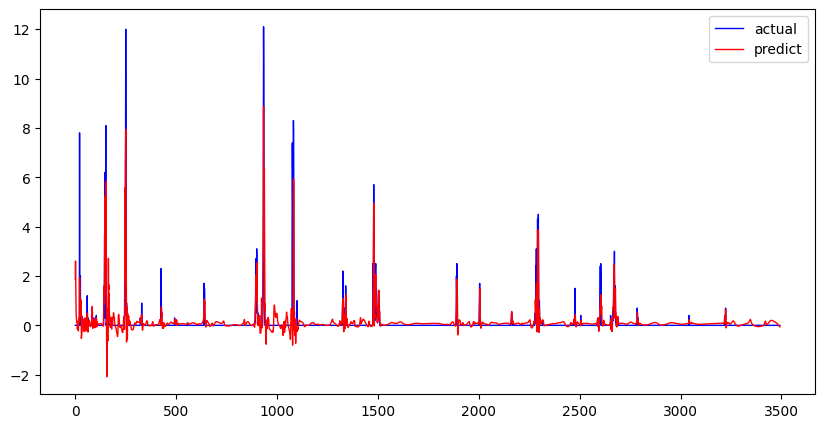

In [59]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [60]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [61]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.14445370874942765
MSE: 0.1572621810059046
HMAE: 0.9730346482576991
HMSE: 7.135485230639917
R^2: 0.63929347531661


In [62]:
# 将预测结果中小于0的值设置为0
y_pre_total[y_pre_total < 0] = 0

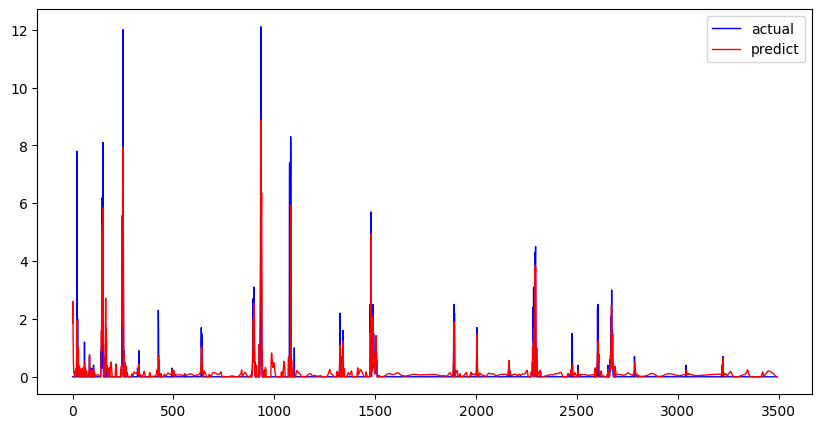

In [63]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [65]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [66]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.12909599426923696
MSE: 0.14657284300030074
HMAE: 0.7880614984954174
HMSE: 5.4619560167482994
R^2: 0.6638112197514445


In [67]:
# import pandas as pd

# # 将 NumPy 数组转换为 DataFrame
# y_pre_total_df = pd.DataFrame(y_pre_total, columns=['Precipitation'])

# # 将 DataFrame 保存为 CSV 文件
# y_pre_total_df.to_csv('/private/数据/GRU-EMDsyprcp.csv', index=False)

In [68]:
# import pandas as pd

# # 将 NumPy 数组转换为 DataFrame
# y_test_all_df = pd.DataFrame(y_test_all, columns=['Precipitation'])

# # 将 DataFrame 保存为 CSV 文件
# y_test_all_df.to_csv('/private/数据/2019-2022syreal.csv', index=False)

# 使用EMD-TCN模型进行预测

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

y_pre_list = []
y_test_list = []
window_size = 12

for column in decompose_data1.columns:
    serie_data = decompose_data1[column]
    x_train, y_train, x_val, y_val, x_test, y_test = get_tain_val_test(serie_data, window_size)
    
    # 在每次循环开始时重新实例化模型
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu', input_shape=(window_size, 1)),
        Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu'),
        Conv1D(filters=64, kernel_size=2, padding='causal', activation='relu'),
        Flatten(),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=16, verbose=1)
    
    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)

# 这里可以添加代码以评估模型性能，比如计算每一列的MSE或MAE


Epoch 1/20


2024-05-16 18:00:18.451534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:0d:00.0, compute capability: 8.6
2024-05-16 18:00:21.163537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-05-16 18:00:21.897042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-16 18:00:21.897416: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb191f1e650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 18:00:21.897427: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-16 18:00:21.901944: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabli

1533/1533 [==============================] - 15s 7ms/step - loss: 1.1804 - val_loss: 0.9746
Epoch 2/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.7098 - val_loss: 0.8070
Epoch 3/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.5900 - val_loss: 0.6974
Epoch 4/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.5845 - val_loss: 0.7773
Epoch 5/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.4894 - val_loss: 0.6526
Epoch 6/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.4728 - val_loss: 0.7095
Epoch 7/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.4613 - val_loss: 0.7453
Epoch 8/20
1533/1533 [==============================] - 11s 7ms/step - loss: 0.4165 - val_loss: 0.6724
Epoch 9/20
1533/1533 [==============================] - 12s 8ms/step - loss: 0.4615 - val_loss: 0.7003
Epoch 10/20
1533/1533 [==============================] - 10s 7ms/step - loss: 0.4330

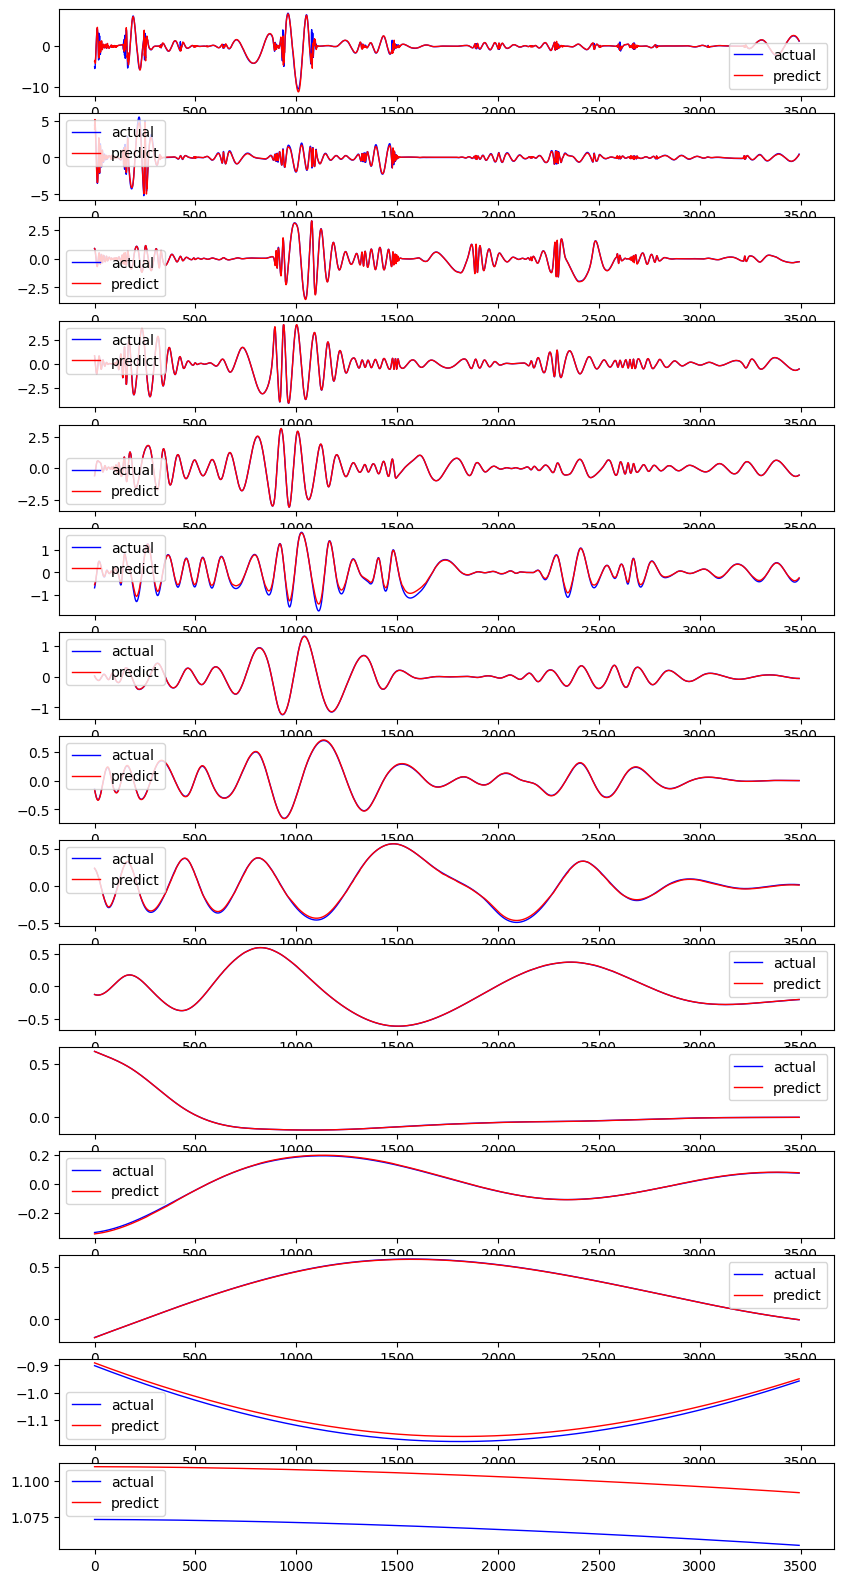

In [37]:
fig = plt.figure(figsize=(10,20))
for i,column in enumerate(decompose_data1.columns):
    
    axes = fig.add_subplot(len(decompose_data1.columns),1,i+1)
    axes.plot(y_test_list[i], 'b-',linewidth = '1', label='actual')
    axes.plot(y_pre_list[i], 'r-', linewidth = '1', label='predict')

    plt.legend()

In [38]:
#此时的预测是对全部分解结果的预测求和
y_pre_total = np.sum(np.array(y_pre_list),axis = 0).reshape(-1)
x_train_all,y_train_all,x_val_all, y_val_all,x_test_all, y_test_all = get_tain_val_test(X1,window_size)

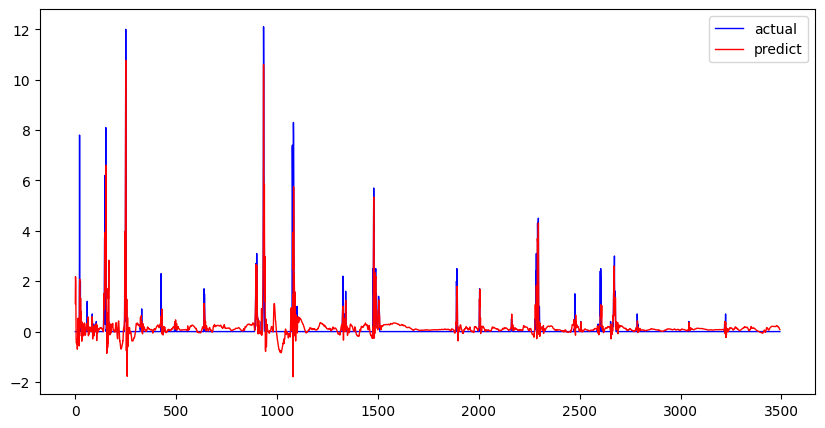

In [39]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [40]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [41]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.19000586916647494
MSE: 0.16406201140187815
HMAE: 1.0620373111800885
HMSE: 5.125704299402695
R^2: 0.6236969525234026


In [42]:
# import pandas as pd

# # 将 NumPy 数组转换为 DataFrame
# y_pre_total_df = pd.DataFrame(y_pre_total, columns=['Precipitation'])

# # 将 DataFrame 保存为 CSV 文件
# y_pre_total_df.to_csv('/private/数据/TCN-EMDsyundeal.csv', index=False)

In [43]:
def apply_threshold(predictions, threshold=0.5):
    # 将负值和接近0的值设置为0
    predictions[predictions < threshold] = 0.0
    return predictions
y_pre_total = apply_threshold(y_pre_total, threshold=0.5)

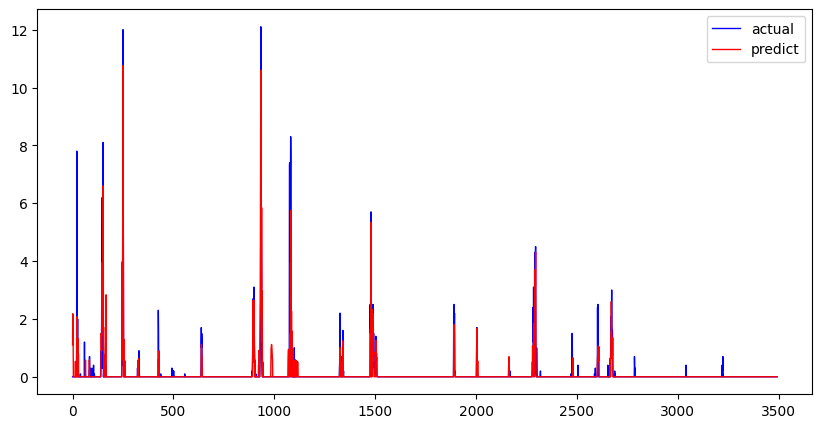

In [44]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [45]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse
from sklearn.metrics import r2_score
r2_train = r2_score(y_test_all, y_pre_total)

In [46]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))
print(f'R^2: {r2_train}')

MAE: 0.06922201267668895
MSE: 0.13633018813855932
HMAE: 0.7370393113482113
HMSE: 15.455565276196713
R^2: 0.6873044233626259


In [47]:
# import pandas as pd

# # 将 NumPy 数组转换为 DataFrame
# y_pre_total_df = pd.DataFrame(y_pre_total, columns=['Precipitation'])

# # 将 DataFrame 保存为 CSV 文件
# y_pre_total_df.to_csv('/private/数据/TCN-EMDsyprcp.csv', index=False)

# CEEMD分解

In [49]:
decompose_data3 = pd.DataFrame(np.vstack((imfs_close1, res_close1)).T,columns = ['IMF%d'%(i+1) for i in range(len(imfs_close1))] + ['Res'])

In [50]:
decompose_data3

IMF1      IMF2      IMF3      IMF4      IMF5      IMF6      IMF7  \
0     -0.232754 -0.148148 -0.077393  0.067619 -0.029300  0.033067  0.036165   
1      0.189064  0.122796  0.008424  0.070325 -0.019351  0.030978  0.040198   
2     -0.226531  0.126285  0.058794  0.071861 -0.014022  0.028158  0.043926   
3      0.222910 -0.116917  0.088673  0.076250 -0.013231  0.024666  0.047333   
4     -0.517027 -0.088394  0.119573  0.085136 -0.016363  0.020646  0.050409   
...         ...       ...       ...       ...       ...       ...       ...   
35037  0.095538  0.051597  0.015339  0.144102 -0.006469 -0.039345 -0.103967   
35038 -0.163344  0.184260 -0.012170  0.189549 -0.005467 -0.040435 -0.104439   
35039 -0.088547  0.150568 -0.040765  0.217877 -0.003578 -0.040725 -0.104641   
35040  0.128325 -0.033998 -0.052308  0.222397 -0.001407 -0.040178 -0.104565   
35041 -0.025405 -0.094338 -0.039017  0.198667  0.000679 -0.038776 -0.104207   

           IMF8      IMF9     IMF10     IMF11     IMF12     IMF13     IMF14  \
0     -0.000073 -0.038025 -0.013986  0.006383 -0.055404 -0.061132  0.042150   
1     -0.000419 -0.038319 -0.013985  0.006389 -0.055411 -0.061139  0.042151   
2     -0.000772 -0.038614 -0.013985  0.006395 -0.055417 -0.061145  0.042153   
3     -0.001136 -0.038912 -0.013985  0.006401 -0.055424 -0.061152  0.042155   
4     -0.001512 -0.039212 -0.013986  0.006406 -0.055431 -0.061158  0.042156   
...         ...       ...       ...       ...       ...       ...       ...   
35037 -0.030213 -0.000010  0.014244 -0.021803 -0.128415 -0.012333  0.067149   
35038 -0.030870 -0.000204  0.014137 -0.021808 -0.128392 -0.012331  0.067146   
35039 -0.031487 -0.000395  0.014031 -0.021812 -0.128369 -0.012329  0.067144   
35040 -0.032061 -0.000581  0.013924 -0.021817 -0.128346 -0.012327  0.067141   
35041 -0.032590 -0.000764  0.013819 -0.021822 -0.128322 -0.012326  0.067138   

          IMF15     IMF16       Res  
0      0.110765  0.116608  0.243460  
1      0.110765  0.116608 -0.549075  
2      0.110765  0.116608 -0.194458  
3      0.110765  0.116608 -0.435004  
4      0.110765  0.116608  0.241381  
...         ...       ...       ...  
35037  0.141140  0.109448 -0.296000  
35038  0.141141  0.109447 -0.186219  
35039  0.141142  0.109447 -0.227559  
35040  0.141142  0.109447 -0.254786  
35041  0.141143  0.109447 -0.033325  

[35042 rows x 17 columns]

# 使用CEEMD-GRU进行预测